# Самостоятельный проект. Обучение с учителем: качество модели

# Описание проекта
Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.

Руководство компании хочет принимать решения только на основе анализа данных и бизнес-моделирования.  

**ЦЕЛЬ:** _Необходимо разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность._
  
**Задачи:**  

- Нужно построить модель, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца.
- В исследование нужно включить дополнительные данные финансового департамента о прибыльности клиента: какой доход каждый покупатель приносил компании за последние три месяца.
- Используя данные модели и данные о прибыльности клиентов, нужно выделить сегменты покупателей и разработать для них персонализированные предложения.

**Подход к решению задачи:** 

- Нужно промаркировать уровень финансовой активности постоянных покупателей. В компании принято выделять два уровня активности: «снизилась», если клиент стал покупать меньше товаров, и «прежний уровень».    
  
  
- Нужно собрать данные по клиентам по следующим группам:
   - Признаки, которые описывают коммуникацию сотрудников компании с клиентом.
   - Признаки, которые описывают продуктовое поведение покупателя. Например, какие товары покупает и как часто.
   - Признаки, которые описывают покупательское поведение клиента. Например, сколько тратил в магазине.
   - Признаки, которые описывают поведение покупателя на сайте. Например, как много страниц просматривает и сколько времени проводит на сайте.

# Описание данных
Данные для работы находятся в нескольких таблицах.  

`market_file.csv`
Таблица, которая содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении. 
- id — номер покупателя в корпоративной базе данных.
- Покупательская активность — рассчитанный класс покупательской активности (целевой признак): «снизилась» или «прежний уровень».
- Тип сервиса — уровень сервиса, например «премиум» и «стандарт».
- Разрешить сообщать — информация о том, можно ли присылать покупателю дополнительные предложения о товаре. Согласие на это даёт покупатель.
- Маркет_актив_6_мес — среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента.
- Маркет_актив_тек_мес — количество маркетинговых коммуникаций в текущем месяце.
- Длительность — значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте.
- Акционные_покупки — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев.
- Популярная_категория — самая популярная категория товаров у покупателя за последние 6 месяцев.
- Средний_просмотр_категорий_за_визит — показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца.
- Неоплаченные_продукты_штук_квартал — общее число неоплаченных товаров в корзине за последние 3 месяца.
- Ошибка_сервиса — число сбоев, которые коснулись покупателя во время посещения сайта.
- Страниц_за_визит — среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.

`market_money.csv`
Таблица с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.
- id — номер покупателя в корпоративной базе данных.
- Период — название периода, во время которого зафиксирована выручка. Например, 'текущий_месяц' или 'предыдущий_месяц'.
- Выручка — сумма выручки за период.

`market_time.csv`
Таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода.
- id — номер покупателя в корпоративной базе данных.
- Период — название периода, во время которого зафиксировано общее время.
- минут — значение времени, проведённого на сайте, в минутах.

`money.csv`
Таблица с данными о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.
- id — номер покупателя в корпоративной базе данных.
- Прибыль — значение прибыли.

In [1]:
!pip install phik -q
!pip install shap -q

import numpy as np
import pandas as pd
from math import sqrt
from scipy import stats as st
import textwrap


from matplotlib import pyplot as plt
from matplotlib import rcParams, rcParamsDefault
import plotly.express as px
import seaborn as sns


import phik


# загружаем класс pipeline
from sklearn.pipeline import Pipeline

# загружаем классы для подготовки данных
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import StratifiedKFold

# загружаем класс для работы с пропусками
from sklearn.impute import SimpleImputer

# загружаем функцию для работы с метриками
from sklearn.metrics import (roc_auc_score,
                             precision_score,
                             recall_score,
                             confusion_matrix
                            )


# импортируем класс RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV

# загружаем нужные модели
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

#для оценки признаков
import shap


RANDOM_STATE = 42
TEST_SIZE = 0.25


# Подавляем FutureWarning, вызванный изменением поведения функции `mode`
import warnings
import scipy.stats
warnings.filterwarnings("ignore", category=FutureWarning, module="scipy.stats")

#чтобы не было красных предупреждений
with warnings.catch_warnings():
    warnings.simplefilter("ignore", FutureWarning)

## Загрузка данных

### Загрузите данные  
Файлы `market_file.csv`, `market_money.csv`, `market_time.csv`, `money.csv`

In [2]:
#загружаем файл market_file.csv 
#данные о поведении покупателя на сайте, 
#о коммуникациях с покупателем и его продуктовом поведении.
try:
    market_file = pd.read_csv('C:/Users/Student/Desktop//market_file.csv')
except:
    market_file = pd.read_csv('/datasets/market_file.csv')
#проверяем, что данные в таблицах соответствуют описанию
market_file.head()

id Покупательская активность Тип сервиса Разрешить сообщать  \
0  215348                 Снизилась     премиум                 да   
1  215349                 Снизилась     премиум                 да   
2  215350                 Снизилась   стандартт                нет   
3  215351                 Снизилась   стандартт                 да   
4  215352                 Снизилась   стандартт                нет   

   Маркет_актив_6_мес  Маркет_актив_тек_мес  Длительность  Акционные_покупки  \
0                 3.4                     5           121               0.00   
1                 4.4                     4           819               0.75   
2                 4.9                     3           539               0.14   
3                 3.2                     5           896               0.99   
4                 5.1                     3          1064               0.94   

  Популярная_категория  Средний_просмотр_категорий_за_визит  \
0     Товары для детей                                    6   
1     Товары для детей                                    4   
2    Домашний текстиль                                    5   
3     Товары для детей                                    5   
4     Товары для детей                                    3   

   Неоплаченные_продукты_штук_квартал  Ошибка_сервиса  Страниц_за_визит  
0                                   2               1                 5  
1                                   4               2                 5  
2                                   2               1                 5  
3                                   0               6                 4  
4                                   2               3                 2

In [3]:
#загружаем файл market_money.csv 
#данные о выручке, которую получает магазин с покупателя за период взаимодействия с сайтом.
try:
    market_money = pd.read_csv('C:/Users/Student/Desktop//market_money.csv')
except:
    market_money = pd.read_csv('/datasets/market_money.csv')
# проверяем, что данные в таблицах соответствуют описанию
market_money.head()

id               Период  Выручка
0  215348  препредыдущий_месяц      0.0
1  215348        текущий_месяц   3293.1
2  215348     предыдущий_месяц      0.0
3  215349  препредыдущий_месяц   4472.0
4  215349        текущий_месяц   4971.6

In [4]:
#загружаем файл market_time.csv
#данные о времени (в минутах), которое покупатель провёл на сайте в течение периода взаимодействия с сайтом.
try:
    market_time = pd.read_csv('C:/Users/Student/Desktop//market_time.csv')
except:
    market_time = pd.read_csv('/datasets/market_time.csv')
#проверяем, что данные в таблицах соответствуют описанию
market_time.head()

id            Период  минут
0  215348     текущий_месяц     14
1  215348  предыдцщий_месяц     13
2  215349     текущий_месяц     10
3  215349  предыдцщий_месяц     12
4  215350     текущий_месяц     13

In [5]:
#загружаем файл money.csv
#данные о времени (в минутах), которое покупатель провёл на сайте в течение периода взаимодействия с сайтом.
try:
    money = pd.read_csv('C:/Users/Student/Desktop//money.csv', sep = ';')
except:
    money = pd.read_csv('/datasets/money.csv', sep= ';', decimal=',')
#проверяем, что данные в таблицах соответствуют описанию
money.head()

id  Прибыль
0  215348     0.98
1  215349     4.16
2  215350     3.13
3  215351     4.87
4  215352     4.21

Данные из столбца `Прибыль` из money.csv загрузилсись в формате 1,23 , то есть с ","  как символом для разделения целой и дробной части числа. По рекомендации ревьюера из прошлого проекта , можно сразу же при заугрзке указать параметр decimal=',', чтобы привести данные к формату 1.23

Данные загружены, данные совпадают с описанием. Перейдем к следующему этапу - предобработке данных. 

##  Предобработка данных

### Переименование столбцов

Хоть заказчик и допускает кириллические названия, но признаком хорошего тона негласно является название столбцов на латинице. Поэтому приведем названия всех столбцов к такому виду.

In [6]:
market_file = market_file.rename(
    columns={
        'Покупательская активность': 'consumer_activity',
        'Тип сервиса': 'service_class',
        'Разрешить сообщать': 'offer_allow',
        'Маркет_актив_6_мес': 'advert_6_m',
        'Маркет_актив_тек_мес': 'advert_current_m',
        'Длительность': 'duration_days',
        'Акционные_покупки': 'promo_purchases',
        'Популярная_категория': 'popular_category',
        'Средний_просмотр_категорий_за_визит': 'avr_category_views',
        'Неоплаченные_продукты_штук_квартал': 'unpaid_pcs_left_bag_quarter',
        'Ошибка_сервиса': 'site_bugs',
        'Страниц_за_визит': 'pages_per_visit_3m' 
    }
)


market_money = market_money.rename(
    columns={
        'Период': 'period_market_money',
        'Выручка': 'revenue'
    }
)

market_time = market_time.rename(
    columns={
        'Период': 'period_market_time',
        'минут': 'mins'
    }
)

money = money.rename(
    columns={
        'Прибыль': 'profit'
    }
)

### Приведние числовых данные к числовому формату

Посмотрим на данные побробнее.

In [7]:
#данные о поведении покупателя на сайте
market_file.info()
market_file.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           1300 non-null   int64  
 1   consumer_activity            1300 non-null   object 
 2   service_class                1300 non-null   object 
 3   offer_allow                  1300 non-null   object 
 4   advert_6_m                   1300 non-null   float64
 5   advert_current_m             1300 non-null   int64  
 6   duration_days                1300 non-null   int64  
 7   promo_purchases              1300 non-null   float64
 8   popular_category             1300 non-null   object 
 9   avr_category_views           1300 non-null   int64  
 10  unpaid_pcs_left_bag_quarter  1300 non-null   int64  
 11  site_bugs                    1300 non-null   int64  
 12  pages_per_visit_3m           1300 non-null   int64  
dtypes: float64(2), int

id   advert_6_m  advert_current_m  duration_days  \
count    1300.000000  1300.000000       1300.000000    1300.000000   
mean   215997.500000     4.253769          4.011538     601.898462   
std       375.421985     1.014814          0.696868     249.856289   
min    215348.000000     0.900000          3.000000     110.000000   
25%    215672.750000     3.700000          4.000000     405.500000   
50%    215997.500000     4.200000          4.000000     606.000000   
75%    216322.250000     4.900000          4.000000     806.000000   
max    216647.000000     6.600000          5.000000    1079.000000   

       promo_purchases  avr_category_views  unpaid_pcs_left_bag_quarter  \
count      1300.000000          1300.00000                  1300.000000   
mean          0.319808             3.27000                     2.840000   
std           0.249843             1.35535                     1.971451   
min           0.000000             1.00000                     0.000000   
25%           0.170000             2.00000                     1.000000   
50%           0.240000             3.00000                     3.000000   
75%           0.300000             4.00000                     4.000000   
max           0.990000             6.00000                    10.000000   

         site_bugs  pages_per_visit_3m  
count  1300.000000         1300.000000  
mean      4.185385            8.176923  
std       1.955298            3.978126  
min       0.000000            1.000000  
25%       3.000000            5.000000  
50%       4.000000            8.000000  
75%       6.000000           11.000000  
max       9.000000           20.000000

In [8]:
#данные о выручке, которую получает магазин с покупателя за период
market_money.info()
market_money.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   3900 non-null   int64  
 1   period_market_money  3900 non-null   object 
 2   revenue              3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


id        revenue
count    3900.000000    3900.000000
mean   215997.500000    5025.696051
std       375.325686    1777.704104
min    215348.000000       0.000000
25%    215672.750000    4590.150000
50%    215997.500000    4957.500000
75%    216322.250000    5363.000000
max    216647.000000  106862.200000

In [9]:
#данные о времени (в минутах), которое покупатель провёл на сайте в течение периода
market_time.info()
market_time.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   id                  2600 non-null   int64 
 1   period_market_time  2600 non-null   object
 2   mins                2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


id         mins
count    2600.000000  2600.000000
mean   215997.500000    13.336154
std       375.349754     4.080198
min    215348.000000     4.000000
25%    215672.750000    10.000000
50%    215997.500000    13.000000
75%    216322.250000    16.000000
max    216647.000000    23.000000

In [10]:
#данные о среднемесячной прибыли покупателя за последние 3 месяца
money.info()
money.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      1300 non-null   int64  
 1   profit  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


id       profit
count    1300.000000  1300.000000
mean   215997.500000     3.996631
std       375.421985     1.013722
min    215348.000000     0.860000
25%    215672.750000     3.300000
50%    215997.500000     4.045000
75%    216322.250000     4.670000
max    216647.000000     7.430000

In [11]:
#сделаем замер исходных датасетов до удаления пропусков и дубликатов
temp0_market_file = market_file.copy() # создаем копию датасета до преобразования
print('исходные данные о поведении покупателя на сайте - market_file:', len(temp0_market_file))

temp0_market_money = market_money.copy()
print('исходные данные о выручке, которую получает магазин с покупателя за период - market_money:', len(temp0_market_money))

temp0_market_time = market_time.copy()
print('исходные данные о времени (в минутах), которое покупатель провёл на сайте в течение периода - market_time:', len(temp0_market_time))

temp0_money = money.copy()
print('исходные данные о среднемесячной прибыли покупателя за последние 3 месяца - money:', len(temp0_money))

исходные данные о поведении покупателя на сайте - market_file: 1300
исходные данные о выручке, которую получает магазин с покупателя за период - market_money: 3900
исходные данные о времени (в минутах), которое покупатель провёл на сайте в течение периода - market_time: 2600
исходные данные о среднемесячной прибыли покупателя за последние 3 месяца - money: 1300


Типы данных в порядке, дополнительных преобразований не требуется.  

Пропуски в данных отсутствуют.

### Поиск и удаление дубликатов

Проверим наличие неявных дубликатов в категориальных данных.

In [12]:
def cat_duplicates(data):
    cat_columns_name = data.select_dtypes(exclude='number').columns.tolist()
    for name in cat_columns_name:
    #Изменим регистр в данных, чтобы убрать излишнюю уникальность из-за больших и маленьких букв.
        data[name] = data[name].str.lower()
        print(name)
        print(data[name].value_counts())
        print()
        
print('market_file')
cat_duplicates(market_file)
print('_________________')
print('')
print('market_money')
cat_duplicates(market_money)
print('_________________')
print('')
print('market_time')
cat_duplicates(market_time)
print('_________________')
print('')
print('money')
cat_duplicates(money)

market_file
consumer_activity
прежний уровень    802
снизилась          498
Name: consumer_activity, dtype: int64

service_class
стандарт     914
премиум      376
стандартт     10
Name: service_class, dtype: int64

offer_allow
да     962
нет    338
Name: offer_allow, dtype: int64

popular_category
товары для детей                        330
домашний текстиль                       251
косметика и аксесуары                   223
техника для красоты и здоровья          184
мелкая бытовая техника и электроника    174
кухонная посуда                         138
Name: popular_category, dtype: int64

_________________

market_money
period_market_money
предыдущий_месяц       1300
текущий_месяц          1300
препредыдущий_месяц    1300
Name: period_market_money, dtype: int64

_________________

market_time
period_market_time
предыдцщий_месяц    1300
текущий_месяц       1300
Name: period_market_time, dtype: int64

_________________

money


Обнаружены неявные дубликаты 
- в датасете `market_file` в столбце service_class;
- в датасете `market_money` в столбце period.
Обнаружены опечатки
- в датасете `market_time` в столбце period.

Исправим.

In [13]:
market_file['service_class'] = market_file['service_class'].str.replace('стандартт', 'стандарт')
market_money['period_market_money'] = market_money['period_market_money'].str.replace('препредыдущий_месяц', 'позапрошлый_месяц')
market_time['period_market_time'] = market_time['period_market_time'].str.replace('предыдцщий_месяц', 'предыдущий_месяц')

Проверим наличие явных дубликатов. 

In [14]:
print('market_file:', market_file.duplicated().sum())
print('market_money:', market_money.duplicated().sum())
print('market_time:', market_time.duplicated().sum())
print('money:', money.duplicated().sum())

market_file: 0
market_money: 0
market_time: 0
money: 0


Категориальный данные приведены к одному виду, явные дубликаты удалены, неявные изменены , устранена излишняя уникальность, возникшая из-за разного написаная одних и тех же данных.

### Анализ числовых значений

исходные данные о поведении покупателя на сайте - market_file:


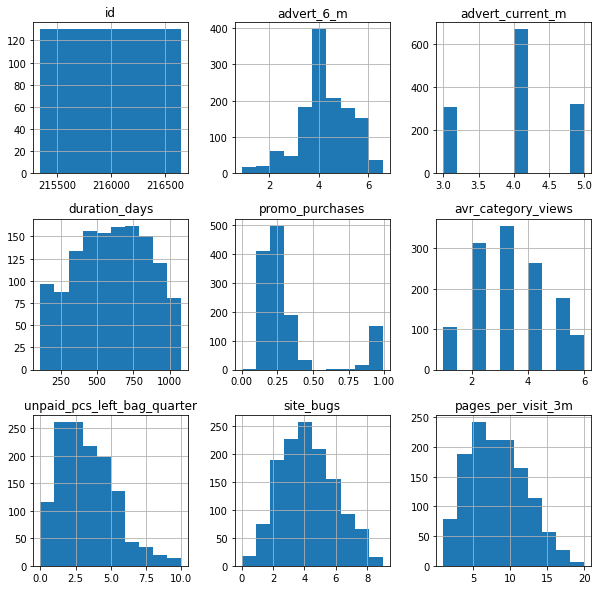

In [15]:
print('исходные данные о поведении покупателя на сайте - market_file:')
market_file.hist(figsize=(10, 10));


исходные данные о выручке, которую получает магазин с покупателя за период - market_money:


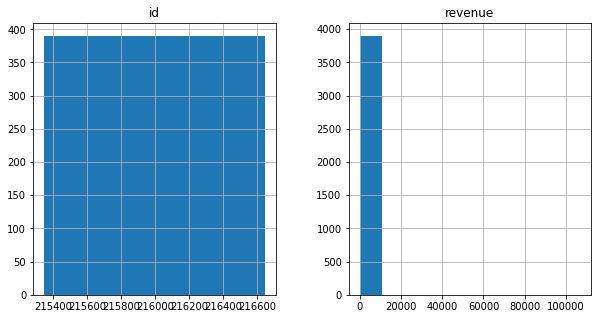

In [16]:
print('исходные данные о выручке, которую получает магазин с покупателя за период - market_money:')
market_money.hist(figsize=(10, 5));

В данные по выручке есть выбросы, изучим их более подробно в следующем шаге. 

исходные данные о времени (в минутах), которое покупатель провёл на сайте в течение периода - market_time:


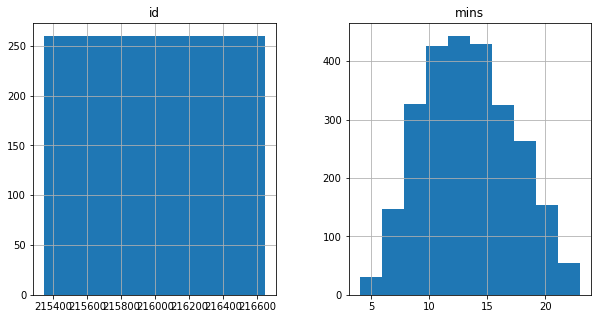

In [17]:
print('исходные данные о времени (в минутах), которое покупатель провёл на сайте в течение периода - market_time:')
market_time.hist(figsize=(10, 5));


исходные данные о среднемесячной прибыли покупателя за последние 3 месяца - money:


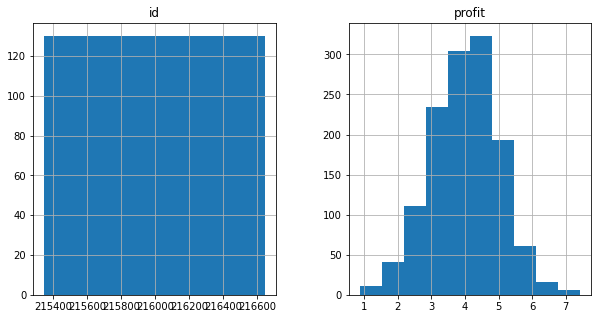

In [18]:
print('исходные данные о среднемесячной прибыли покупателя за последние 3 месяца - money:')
money.hist(figsize=(10, 5));

Аномалий и выбросов на данном этапе выявлены в данных о выручке, изучим и при необходимости избавимся от них на следующем этапе.   
По распределению данные чаще имеют нормальное распределение или распредедение Пуассона.  

Названия столбцов приведены к одному виду, данные приведены к одному регистру. Выявлены неявные дубликаты и исправлены.
Далее проведем исследовательский анализ и изучим данные более подробно

## Исследовательский анализ данных

### Проведите исследовательский анализ данных из каждой таблицы

Для более лаконичного проведения исследовательского анализа данных создадим функции построения гистограмм , боксплотов для силовых признаков, и столбчатых диаграм для категориальных признаков.

In [19]:
def eda_number(data, column, plot_title, x_label, histcolor):
#построение гистограммы с медианой и средним
    plt.figure(figsize=(10, 4))
    bins = plt.hist(data[column], bins=50)
    plt.hist(data[column], bins=50, color=histcolor)
    plt.vlines(x=data[column].mean(), colors='blue', ymin=bins[0].min(), ymax=bins[0].max(), label='Среднее')
    plt.vlines(x=data[column].median(), colors='red', ymin=bins[0].min(), ymax=bins[0].max(), linestyles='--', label='Медиана')
    plt.legend()
    plt.ylabel('Частота')
    plt.title(plot_title)

#ящик с усами 
    plt.figure(figsize=(10, 4))
    plt.boxplot(data[column], vert=False)
    plt.ylabel('Частота')
    plt.xlabel(x_label)
    
    plt.show()
    
    display(data[column].describe())

In [20]:
def eda_category(data_1, data_2, column, plot_title, barhcolor):


    data_group = pd.concat([data_1, data_2], axis=0).groupby(column)[column].count()
    data_group_1 = data_1.groupby(column)[column].count()
    data_group_2 = data_2.groupby(column)[column].count()
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 7))
    
    plt.title(plot_title)   

    wrapped_labels = [textwrap.fill(label, 11) for label in data_group.index]

    axes[0].pie(data_group,
            labels=wrapped_labels,
            wedgeprops = {'linewidth' : 3, 'edgecolor' : 'white'},
            autopct='%1.2f%%',
            colors={barhcolor, None},
           )    

    axes[1].pie(data_group_1,
            labels=wrapped_labels,
            wedgeprops = {'linewidth' : 3, 'edgecolor' : 'white'},
            autopct='%1.2f%%',
            colors={barhcolor, None},
           )    
    
    axes[2].pie(data_group_2,
            labels=wrapped_labels,
            wedgeprops = {'linewidth' : 3, 'edgecolor' : 'white'},
            autopct='%1.2f%%',
            colors={barhcolor, None},
           )
    plt.show()


In [21]:
def eda_category_sum(data_1, data_2, column, column_sum, plot_title, barhcolor):


    data_group = pd.concat([data_1, data_2], axis=0).groupby(column)[column_sum].sum()
    data_group_1 = data_1.groupby(column)[column_sum].sum()
    data_group_2 = data_2.groupby(column)[column_sum].sum()
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 7))
    
    plt.title(plot_title)   

    wrapped_labels = [textwrap.fill(label, 11) for label in data_group.index]

    axes[0].pie(data_group,
            labels=wrapped_labels,
            wedgeprops = {'linewidth' : 3, 'edgecolor' : 'white'},
            autopct='%1.2f%%',
            colors={barhcolor, None},
           )    

    axes[1].pie(data_group_1,
            labels=wrapped_labels,
            wedgeprops = {'linewidth' : 3, 'edgecolor' : 'white'},
            autopct='%1.2f%%',
            colors={barhcolor, None},
           )    
    
    axes[2].pie(data_group_2,
            labels=wrapped_labels,
            wedgeprops = {'linewidth' : 3, 'edgecolor' : 'white'},
            autopct='%1.2f%%',
            colors={barhcolor, None},
           )
    plt.show()


#### EDA market_file - данные о поведении покупателя на сайте

**Количественные признаки market_file:**

In [22]:
#разделим датасет на два по целевому признаку

market_file_1 = market_file[market_file['consumer_activity'] == 'снизилась']
market_file_0 = market_file[market_file['consumer_activity'] == 'прежний уровень']

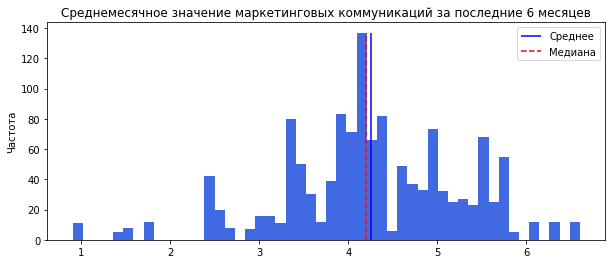

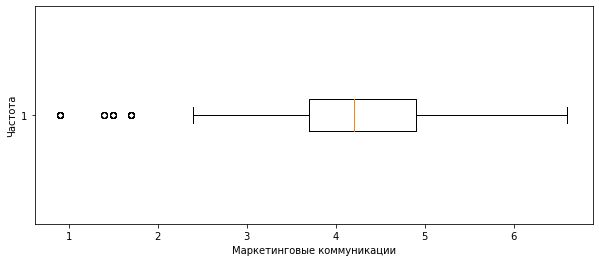

count    1300.000000
mean        4.253769
std         1.014814
min         0.900000
25%         3.700000
50%         4.200000
75%         4.900000
max         6.600000
Name: advert_6_m, dtype: float64

In [23]:
eda_number(market_file,
           'advert_6_m', 
           'Cреднемесячное значение маркетинговых коммуникаций за последние 6 месяцев', 
           'Маркетинговые коммуникации', 'royalblue')

Здесь представлены средние значения коммуникаций по каждому покупателю за полгода, поэтому они дробные , можно предположить, что всего было от 0-7 коммуникаций на покупателя, но в среднем 4шт . Данные смещены чуть вправо, потому что малое количество коммуникаций это редкость . 

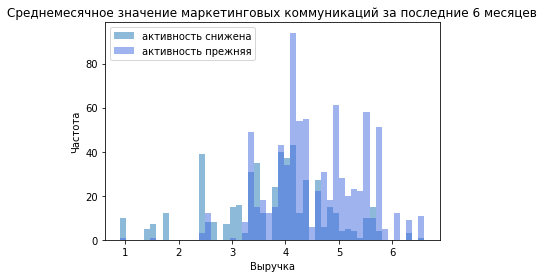

In [24]:
#визуализируем информацию о маркетинговых коммуникациях для пользователей обеих категорий
plt.hist(market_file_1['advert_6_m'], bins=50, alpha=0.5, label='активность снижена')
plt.hist(market_file_0['advert_6_m'], bins=50, alpha=0.5, color="royalblue", label='активность прежняя')
# Добавление подписей осей
plt.xlabel('Выручка')
plt.ylabel('Частота')
plt.title('Cреднемесячное значение маркетинговых коммуникаций за последние 6 месяцев')
plt.legend()
plt.show()

Заметно снижение покупательской активности на меньших оборотах маркетинговых коммуникаций.

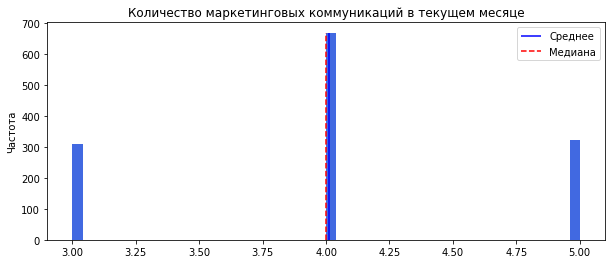

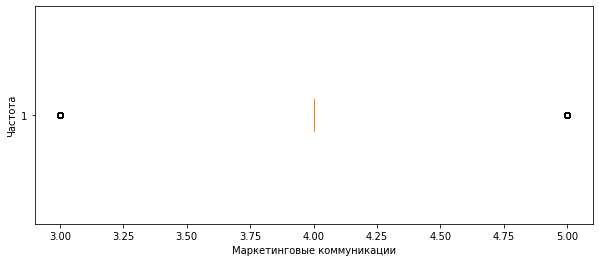

count    1300.000000
mean        4.011538
std         0.696868
min         3.000000
25%         4.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: advert_current_m, dtype: float64

4    669
5    323
3    308
Name: advert_current_m, dtype: int64

In [25]:
eda_number(market_file,
           'advert_current_m', 
           'Количество маркетинговых коммуникаций в текущем месяце', 
           'Маркетинговые коммуникации', 'royalblue')
market_file['advert_current_m'].value_counts()

В текущем месяце наблюдаем уже дискретные величины, было от 3-5 коммуникаций, чаще всего 4.  Данные распредедены нормально.

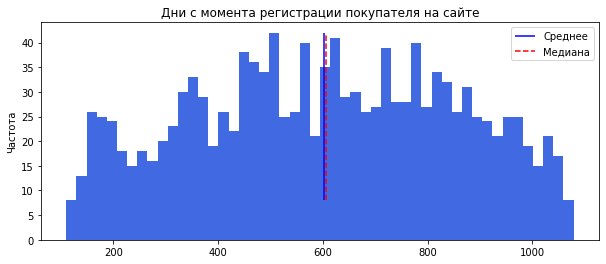

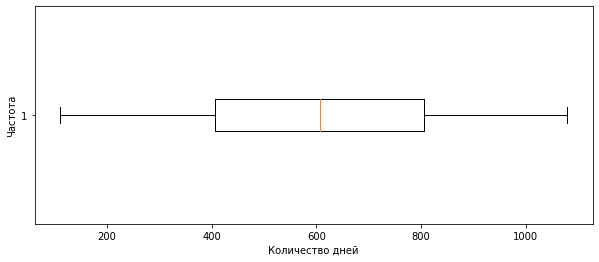

count    1300.000000
mean      601.898462
std       249.856289
min       110.000000
25%       405.500000
50%       606.000000
75%       806.000000
max      1079.000000
Name: duration_days, dtype: float64

In [26]:
eda_number(market_file,
           'duration_days', 
           'Дни с момента регистрации покупателя на сайте', 
           'Количество дней', 'royalblue')

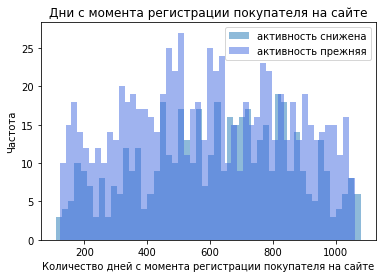

In [27]:
#визуализируем информацию о количестве дней с момента регистрации покупателя на сайте для пользователей обеих категорий
plt.hist(market_file_1['duration_days'], bins=50, alpha=0.5, label='активность снижена')
plt.hist(market_file_0['duration_days'], bins=50, alpha=0.5, color="royalblue", label='активность прежняя')
# Добавление подписей осей
plt.xlabel('Количество дней с момента регистрации покупателя на сайте')
plt.ylabel('Частота')
plt.title('Дни с момента регистрации покупателя на сайте')
plt.legend()
plt.show()

Покупатели из датасета зарегистрированы в течение от 110-1079 дней, то есть даже самые новички пользуются сайтом минимум 3 месяца. Данные распредедены нормально.

Отток пользователей происходит независимо от того сколько дней они зарегистрированы на сайте. 

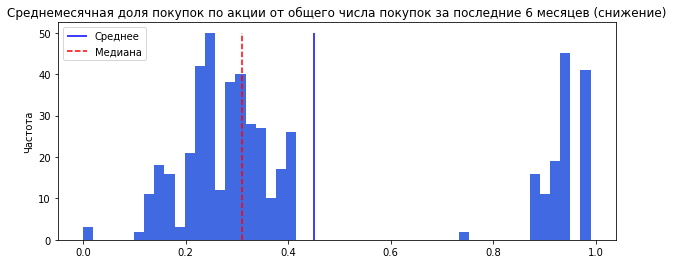

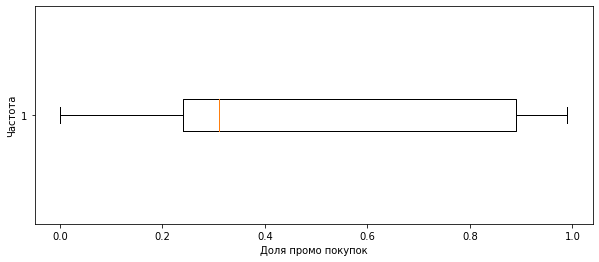

count    498.000000
mean       0.450964
std        0.306011
min        0.000000
25%        0.240000
50%        0.310000
75%        0.890000
max        0.990000
Name: promo_purchases, dtype: float64

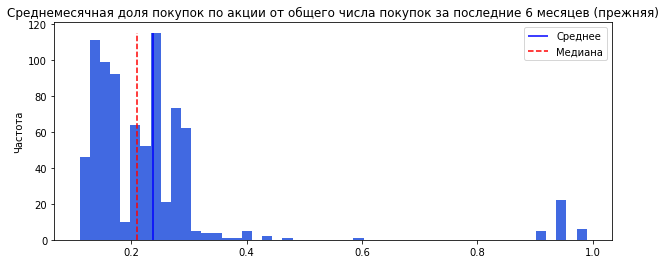

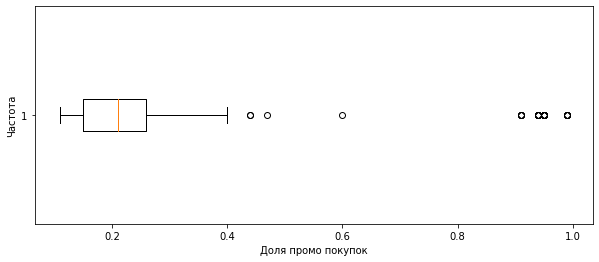

count    802.000000
mean       0.238367
std        0.160599
min        0.110000
25%        0.150000
50%        0.210000
75%        0.260000
max        0.990000
Name: promo_purchases, dtype: float64

In [28]:
eda_number(market_file_1,
           'promo_purchases', 
           'Среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев (снижение)', 
           'Доля промо покупок', 'royalblue')

eda_number(market_file_0,
           'promo_purchases', 
           'Среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев (прежняя)', 
           'Доля промо покупок', 'royalblue')

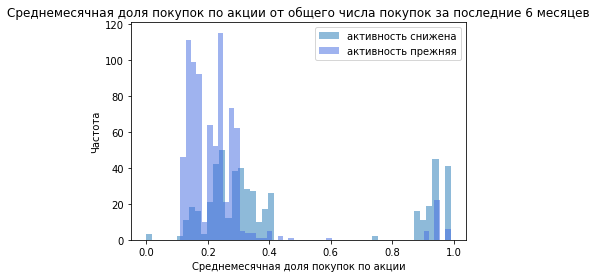

In [29]:
#визуализируем информацию о Среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев для пользователей обеих категорий
plt.hist(market_file_1['promo_purchases'], bins=50, alpha=0.5, label='активность снижена')
plt.hist(market_file_0['promo_purchases'], bins=50, alpha=0.5, color="royalblue", label='активность прежняя')
# Добавление подписей осей
plt.xlabel('Среднемесячная доля покупок по акции')
plt.ylabel('Частота')
plt.title('Среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев')
plt.legend()
plt.show()

Данные распредедены неравномерно для обеих категорий покупателей, данные имеют два пика и смещены влево.
Для покупателей со снижающейся активностью: крацние значения от 0 до  99%.  Медиана 31%, а среднее 45%, четверть покупателей в 89% покупок предпочтитают акционные товары.  

Для покупателей с прежней активностью: крайние значения 11% и  99%. Медиана 21%, а средне 23,8%, что близко друг к другу, и говорит о низком разбросе данных. В данных на боксплоте видны выбросы, но они не являются аномалиями, так как это нормально не покупать промотовары вообще или покупать почти все товары только из этого раздела.


Клиенты со снижающейся покупательской активностью , в своем "продуктовом портфеле" имеют бОльшую долю акционных товаров.  

Это может свидетельствовать о том , что вся заинтересованность таких покупателей в данном магазине сводится к товарам по акции. 

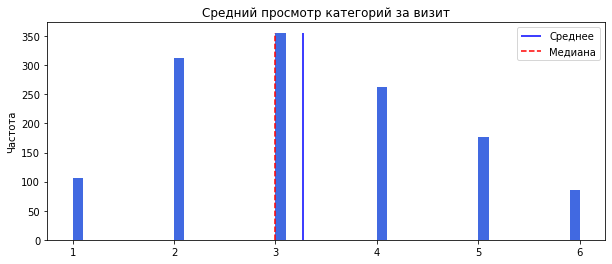

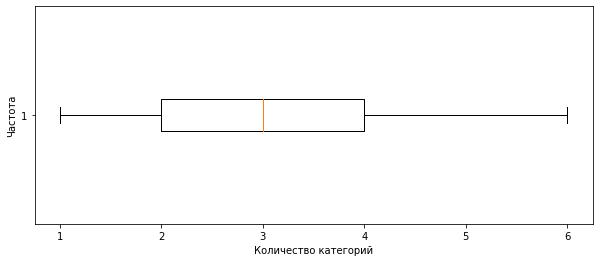

count    1300.00000
mean        3.27000
std         1.35535
min         1.00000
25%         2.00000
50%         3.00000
75%         4.00000
max         6.00000
Name: avr_category_views, dtype: float64

In [30]:
eda_number(market_file,
           'avr_category_views', 
           'Средний просмотр категорий за визит', 
           'Количество категорий', 'royalblue')

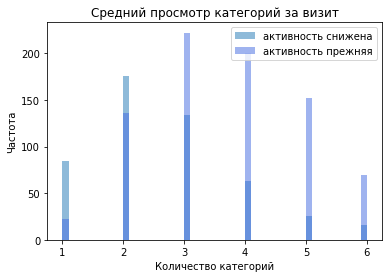

In [31]:
#визуализируем информацию о Среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев для пользователей обеих категорий
plt.hist(market_file_1['avr_category_views'], bins=50, alpha=0.5, label='активность снижена')
plt.hist(market_file_0['avr_category_views'], bins=50, alpha=0.5, color="royalblue", label='активность прежняя')
# Добавление подписей осей
plt.xlabel('Количество категорий')
plt.ylabel('Частота')
plt.title('Средний просмотр категорий за визит')
plt.legend()
plt.show()

Данные распределены нормально. Чаще всего покупатель смотрит 3 категории за визит .Минимум 1, максимум 6.  

Покупатель со сниженной активностью чще  просматривают 3 и меньше категорий.

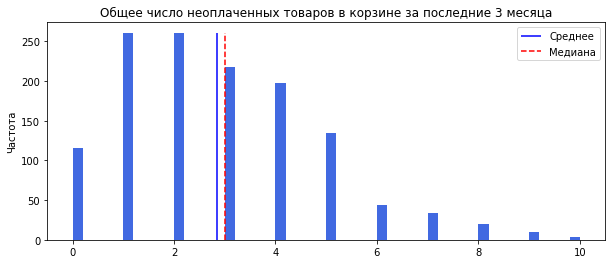

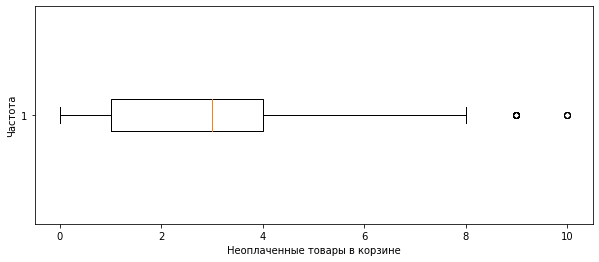

count    1300.000000
mean        2.840000
std         1.971451
min         0.000000
25%         1.000000
50%         3.000000
75%         4.000000
max        10.000000
Name: unpaid_pcs_left_bag_quarter, dtype: float64

In [32]:
eda_number(market_file,
           'unpaid_pcs_left_bag_quarter', 
           'Общее число неоплаченных товаров в корзине за последние 3 месяца', 
           'Неоплаченные товары в корзине', 'royalblue')

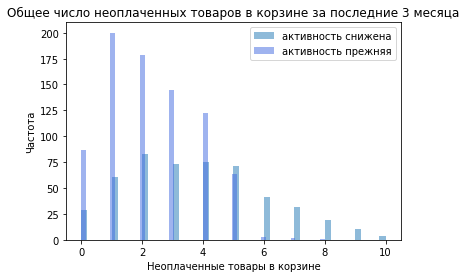

In [33]:
#визуализируем информацию о Среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев для пользователей обеих категорий
plt.hist(market_file_1['unpaid_pcs_left_bag_quarter'], bins=50, alpha=0.5, label='активность снижена')
plt.hist(market_file_0['unpaid_pcs_left_bag_quarter'], bins=50, alpha=0.5, color="royalblue", label='активность прежняя')
# Добавление подписей осей
plt.xlabel('Неоплаченные товары в корзине')
plt.ylabel('Частота')
plt.title('Общее число неоплаченных товаров в корзине за последние 3 месяца')
plt.legend()
plt.show()

По неоплаченные  товарам в корзине минимум 0, максимум 10. Данные немного смещены влево, что говорит о том , что чаще покупатель оставляет в корзине меньше товаров , в среднем это 3 позиции. Аномалий нет , 9 или 10 товаров в корзине это допустимо, просто происходит редко.  

Покупатели со сниженной активностью чаще оставляют больше неопалаченных товаров в корзине.

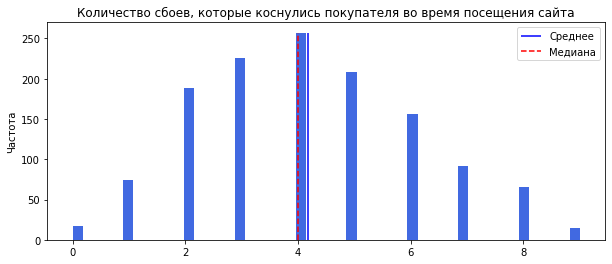

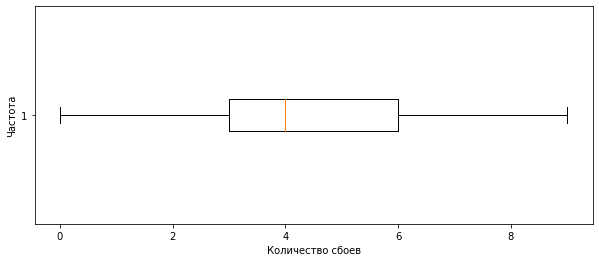

count    1300.000000
mean        4.185385
std         1.955298
min         0.000000
25%         3.000000
50%         4.000000
75%         6.000000
max         9.000000
Name: site_bugs, dtype: float64

In [34]:
eda_number(market_file,
           'site_bugs', 
           'Количество сбоев, которые коснулись покупателя во время посещения сайта', 
           'Количество сбоев', 'royalblue')

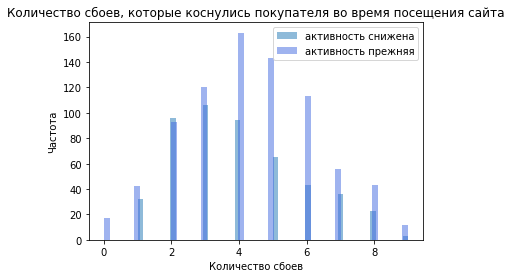

In [35]:
#визуализируем информацию о Среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев для пользователей обеих категорий
plt.hist(market_file_1['site_bugs'], bins=50, alpha=0.5, label='активность снижена')
plt.hist(market_file_0['site_bugs'], bins=50, alpha=0.5, color="royalblue", label='активность прежняя')
# Добавление подписей осей
plt.xlabel('Количество сбоев')
plt.ylabel('Частота')
plt.title('Количество сбоев, которые коснулись покупателя во время посещения сайта')
plt.legend()
plt.show()

Данные распределены нормально , но совсем немного смещены влево, что более благоприятно , чем противоположный вариант.Сбои происходят от 0 до 9, чаще в количестве 4. Покупатели с прежней активностью чаще сталкиваются с багами на сайте чем покупатели со сниженной активностью , потому что их просто больше.

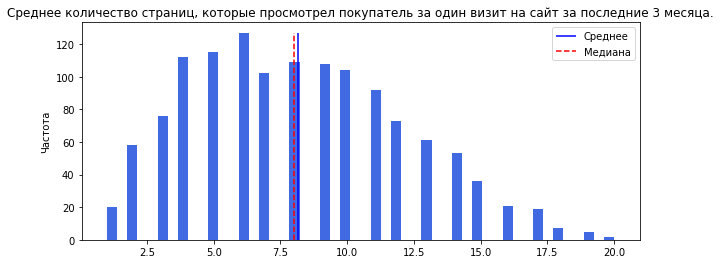

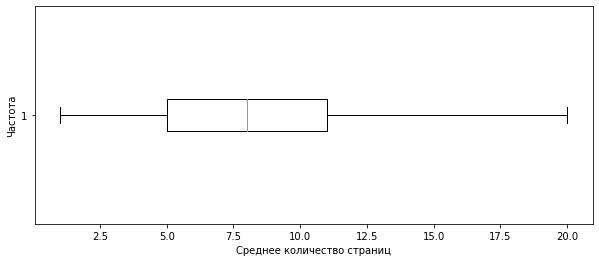

count    1300.000000
mean        8.176923
std         3.978126
min         1.000000
25%         5.000000
50%         8.000000
75%        11.000000
max        20.000000
Name: pages_per_visit_3m, dtype: float64

In [36]:
eda_number(market_file,
           'pages_per_visit_3m', 
           'Среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.', 
           'Среднее количество страниц', 'royalblue')

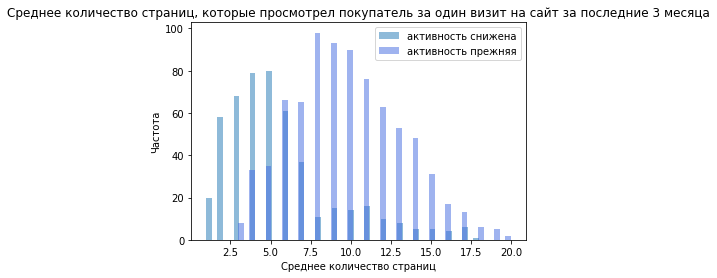

In [37]:
#визуализируем информацию о Среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев для пользователей обеих категорий
plt.hist(market_file_1['pages_per_visit_3m'], bins=50, alpha=0.5, label='активность снижена')
plt.hist(market_file_0['pages_per_visit_3m'], bins=50, alpha=0.5, color="royalblue", label='активность прежняя')
# Добавление подписей осей
plt.xlabel('Среднее количество страниц')
plt.ylabel('Частота')
plt.title('Среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца')
plt.legend()
plt.show()

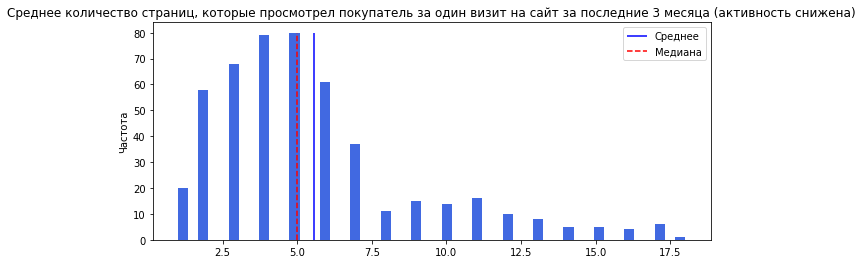

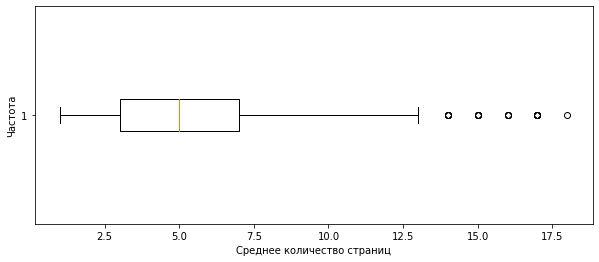

count    498.000000
mean       5.568273
std        3.454265
min        1.000000
25%        3.000000
50%        5.000000
75%        7.000000
max       18.000000
Name: pages_per_visit_3m, dtype: float64

In [38]:
eda_number(market_file_1,
           'pages_per_visit_3m', 
           'Среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца (активность снижена)', 
           'Среднее количество страниц', 'royalblue')

Распределение Пауссона. Данные смещены влево , пользователи просматривают от 1 до 20 страниц, но чаще 8. 

Пользователи со сниженной активностью просматриваю меньше страниц, в среднем 5 страниц. 

**Категориальные признаки market_file:**

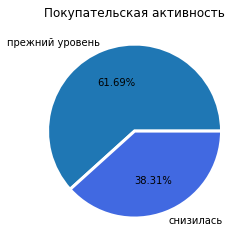

In [39]:
plt.pie(market_file.groupby('consumer_activity')['consumer_activity'].count(),
            labels=market_file.groupby('consumer_activity')['consumer_activity'].count().index,
            wedgeprops = {'linewidth' : 3, 'edgecolor' : 'white'},
            autopct='%1.2f%%',
            colors={'royalblue', None},
           )
plt.title('Покупательская активность') 
plt.show()




Покупательская активность снизилась на 38,31%.  


**В целевом признаке присутствует дисбаланс классов.**

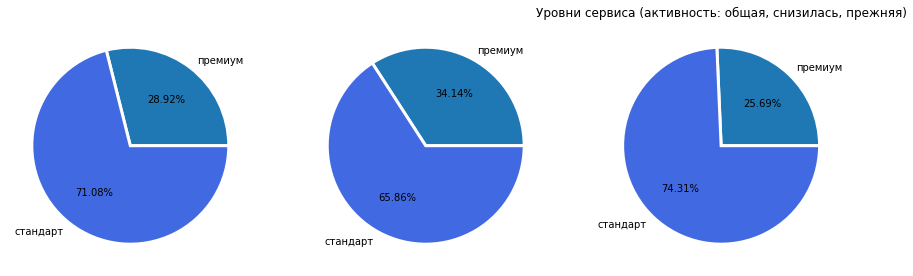

In [40]:
eda_category(market_file_1, market_file_0, 
             'service_class',
             'Уровни сервиса (активность: общая, снизилась, прежняя)',
             'royalblue')

Покупатели распределены на 2 класса сервиса, 28,92 это премиум сервис, 71,08 - стандарт. В разрезе покупательской активности: больше отток покупателей из премиум сегмента 34,14 % против 65,86 % покупателей из стандарт класса.

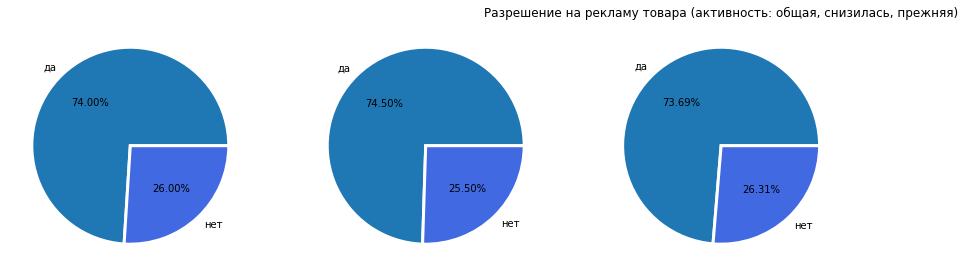

In [41]:
eda_category(market_file_1, market_file_0,
             'offer_allow',
             'Разрешение на рекламу товара (активность: общая, снизилась, прежняя)',
             'royalblue')

Чуть более четверти всех полкупателей в датасете запрещают коммуникационные действия по рекламе, отсальные не против.  

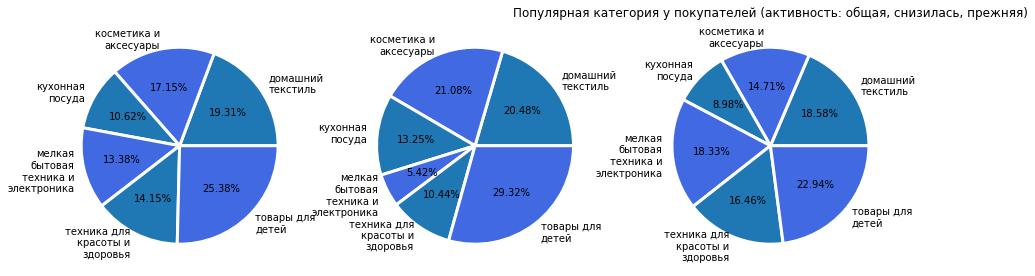

In [42]:
eda_category(market_file_1, market_file_0,
             'popular_category',
             'Популярная категория у покупателей (активность: общая, снизилась, прежняя)',
             'royalblue')

Всего  в магазине 6 категорий товара, самая большая доля приходится на товары для детей  - 25.38%, домашний текстиль - 19.31%, косметику и аксессураы - 17.15%, технику для красоты и здоровья - 14.15%, мелкую бытовую технику - 13.38%, кухонную посуду 10.62%.  

Анализ категориц по покупательской активности.  

29.32% оттока покупателей происходит из категории "товары для детей"- это самая большая категория по численности покупателей, 21.08% косметика и аксессуары, 20.48% домашний текстиль, 70.88 % оттока именно из этих категорий. 
13.25% кухонная посуда  - , 10.44% техника для красоты и здоровья, 5.42% мелкая бытовая техника.

При подготовке данных для модели для этого признака будем  использовать метод кодирования категориальных переменных — OrdinalEncoder.

#### EDA market_money -  данные о выручке, которую получает магазин с покупателя за период 

**Количественные признаки market_money:**

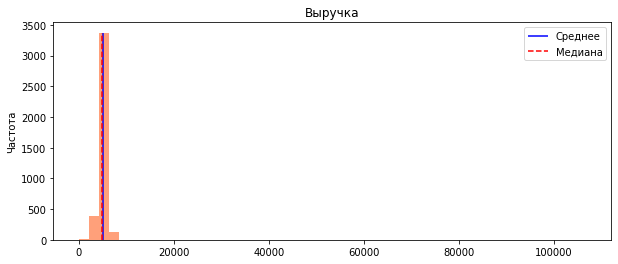

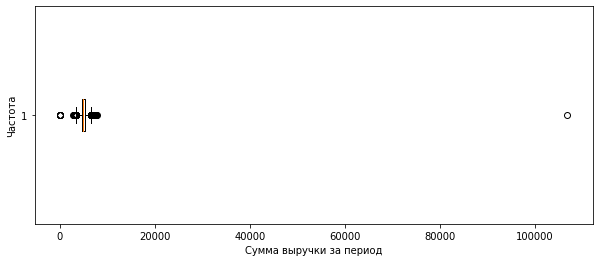

count      3900.000000
mean       5025.696051
std        1777.704104
min           0.000000
25%        4590.150000
50%        4957.500000
75%        5363.000000
max      106862.200000
Name: revenue, dtype: float64

In [43]:
eda_number(market_money,
           'revenue', 
           'Выручка', 
           'Сумма выручки за период', 'lightsalmon'
          )

В данных наблюдается выброс 106862, возможно ошибка в единицах измерения, но удалим эту позицию.

Добавим целевой признак и посмотрим как менялась выручка в разрезе активности покупателей.

In [44]:
market_money = market_money[market_money['revenue']<106862] 

In [45]:
market_money_0 = market_file_0.merge(market_money, on='id', how='left')
market_money_1 = market_file_1.merge(market_money, on='id', how='left')

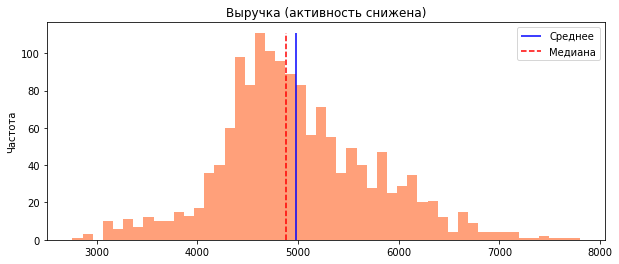

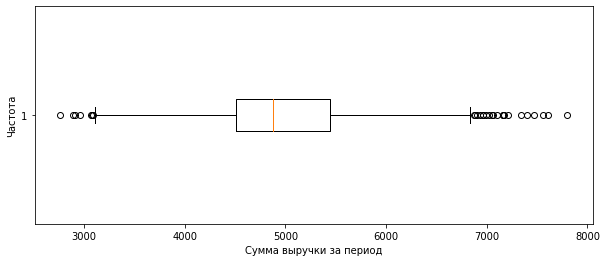

count    1487.000000
mean     4984.690114
std       761.176218
min      2758.700000
25%      4505.000000
50%      4880.000000
75%      5439.000000
max      7799.400000
Name: revenue, dtype: float64

In [46]:
eda_number(market_money_1.query('revenue>0'),
           'revenue', 
           'Выручка (активность снижена)', 
           'Сумма выручки за период', 'lightsalmon'
          )

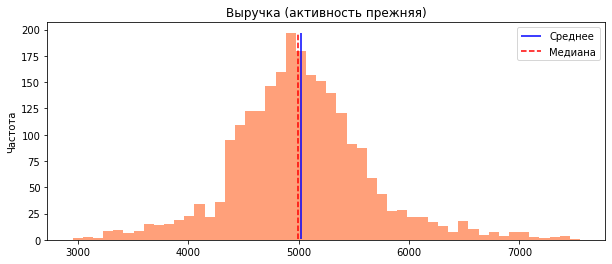

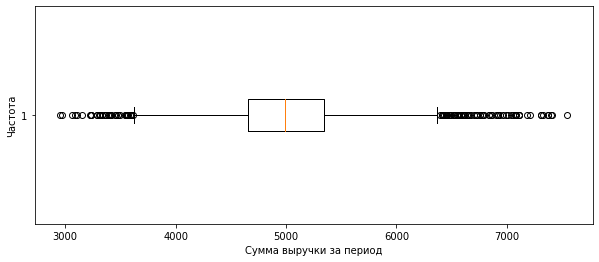

count    2406.000000
mean     5021.246135
std       623.851770
min      2952.200000
25%      4654.250000
50%      4989.700000
75%      5346.125000
max      7547.800000
Name: revenue, dtype: float64

In [47]:
eda_number(market_money_0,
           'revenue', 
           'Выручка (активность прежняя)', 
           'Сумма выручки за период', 'lightsalmon'
          )

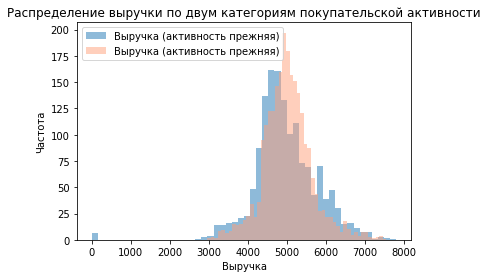

In [48]:
#визуализируем информацию о выручке для пользователей обеих категорий
plt.hist(market_money_1['revenue'], bins=50, alpha=0.5, label='Выручка (активность прежняя)')
plt.hist(market_money_0['revenue'], bins=50, alpha=0.5, color="lightsalmon", label='Выручка (активность прежняя)')
# Добавление подписей осей
plt.xlabel('Выручка')
plt.ylabel('Частота')
plt.title('Распределение выручки по двум категориям покупательской активности')
plt.legend()
plt.show()

Выручка в обеих категориях покупателей примерно на одном уровне. Среднее значение около 5000. Выручка варьируется в пределах от 2759 - 7799 (медиана 4880) у покупателей со сниженной активностью, и от 2952 до 7548 (медиана 4990) у покупателей с прежней активностью.

Сейчас данные в данных остались выбросы, которые не являются аномалиями и вполне могут быть вызможны, как 0 так и редкие значения около 8000. Основная часть данных распределена нормально, средняя выручка в районе 5000 

**Категориальные признаки market_money:**

Каждому пользователю соответствует три периода.

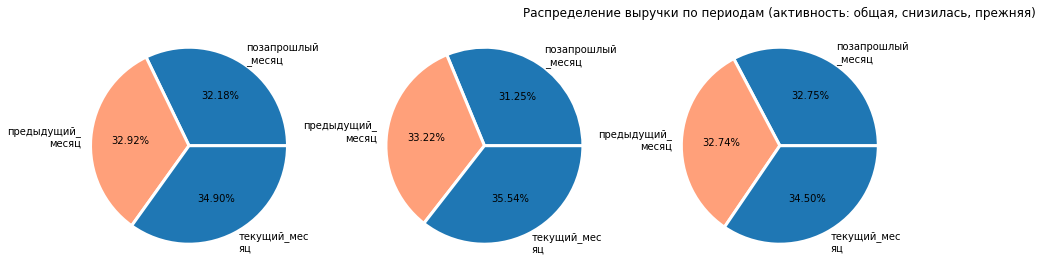

In [49]:
eda_category_sum(market_money_1,
                 market_money_0,
                 'period_market_money',
                 'revenue',
                 'Распределение выручки по периодам (активность: общая, снизилась, прежняя)',
                 'lightsalmon')

В течение 3 месяцев наблюдается небольшой рост выручки , сначала примерно на  0.7%, далее уже на 2% в месяц. В разрезе активности покупателей, у покупателей, у которых наблюдается снижение активности выручка стабильно растет.

#### EDA market_time - данные о времени (в минутах), которое покупатель провёл на сайте в течение периода 

**Количественные признаки market_time:**

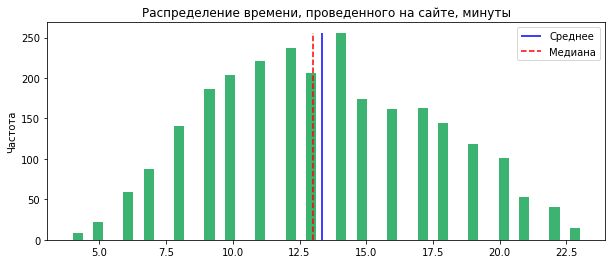

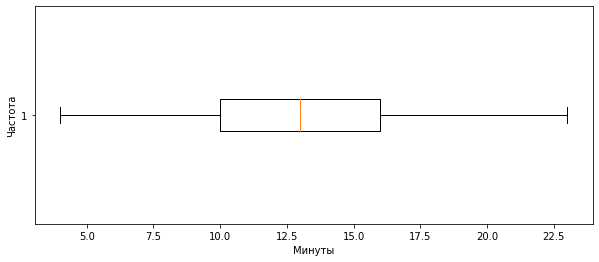

count    2600.000000
mean       13.336154
std         4.080198
min         4.000000
25%        10.000000
50%        13.000000
75%        16.000000
max        23.000000
Name: mins, dtype: float64

In [50]:
eda_number(market_time,
           'mins', 
           'Распределение времени, проведенного на сайте, минуты', 
           'Минуты', 'mediumseagreen'
          )


Добавим целевой признак и посмотрим как менялась выручка в разрезе активности покупателей.

In [51]:
market_time_0 = market_file_0.merge(market_time, on='id', how='left')
market_time_1 = market_file_1.merge(market_time, on='id', how='left')

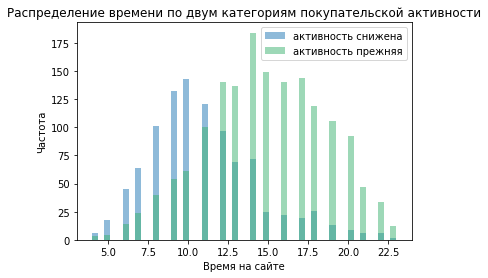

In [52]:
#визуализируем информацию о выручке для пользователей обеих категорий
plt.hist(market_time_1['mins'], bins=50, alpha=0.5, label='активность снижена')
plt.hist(market_time_0['mins'], bins=50, alpha=0.5, color="mediumseagreen", label='активность прежняя')
# Добавление подписей осей
plt.xlabel('Время на сайте')
plt.ylabel('Частота')
plt.title('Распределение времени по двум категориям покупательской активности')
plt.legend()
plt.show()

Все пользователи проводят на сайте от 4-23 минут , но чаще всего около 13 минут. Время, проведенное польщователями на сайте, распределено нормально.  

На гистограмме видно , что пользователи со сниженной активностью проводят на сайте меньше минут чем  те, кто сохраняют свою активность.

**Категориальные признаки market_time:**

Каждому пользователю в таблице соотвествтует два периода. 

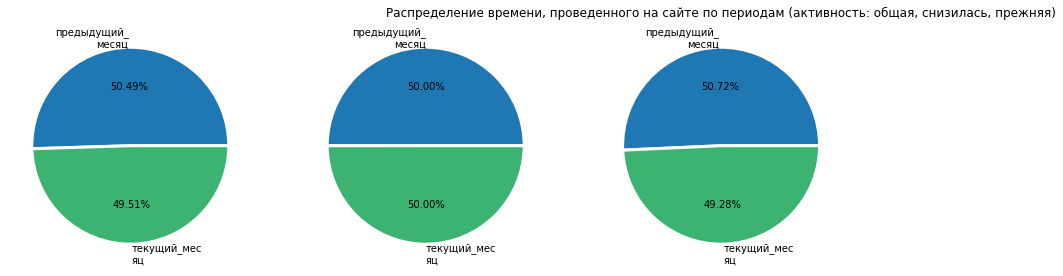

In [53]:

eda_category_sum(market_time_1,
                 market_time_0,
                 'period_market_time', 
                 'mins',
                 'Распределение времени, проведенного на сайте по периодам (активность: общая, снизилась, прежняя)', 
                 'mediumseagreen')

Пользователи проводят на сайте почти то же самое время, что и месяц назад. Для пользователей с разной активностью время проведенное на сайте , практически не меняется. Удивительно , но пользователи  , кототрые сохраняют активность в текущем месяце провели времени даже чуть меньше чем в предыдущем. 

#### EDA money -  данные о среднемесячной прибыли покупателя за последние 3 месяца

Количественные признаки:

Изменим единицы измерения в прибыли , умножив на 100. Разные единицы измерения не так важны для моделей, но изменим , чтобы привсети все к одному виду. 

In [54]:
money['profit'] = money['profit'].apply(lambda x: x * 100)

#устанавливаем id индексом в датасете money
money = money.set_index('id')

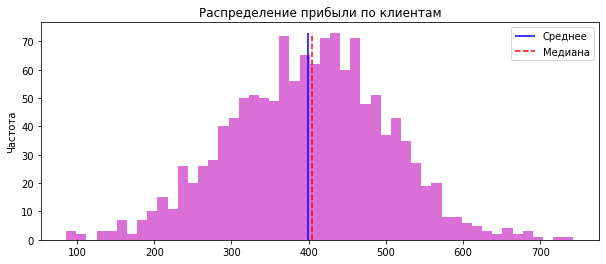

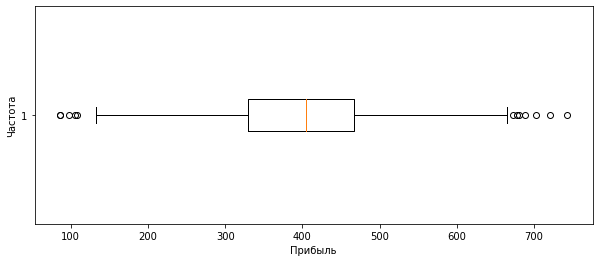

count    1300.000000
mean      399.663077
std       101.372211
min        86.000000
25%       330.000000
50%       404.500000
75%       467.000000
max       743.000000
Name: profit, dtype: float64

In [55]:
eda_number(money,
           'profit', 
           'Распределение прибыли по клиентам', 
           'Прибыль', 'orchid'
          )

Среднемесячная выручка составялет от 86-743 с одного клиента. Данные распредедены нормально, средняя выручка составляет около 4000.

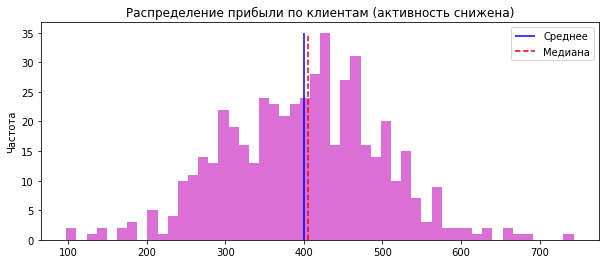

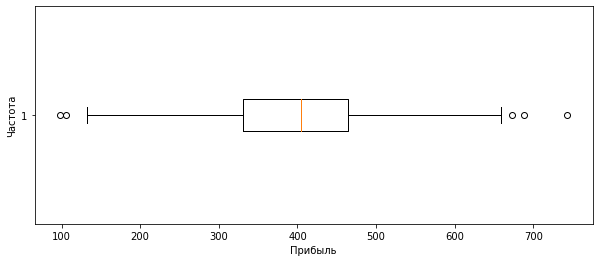

count    498.000000
mean     399.833333
std       98.355258
min       98.000000
25%      330.500000
50%      405.000000
75%      464.000000
max      743.000000
Name: profit, dtype: float64

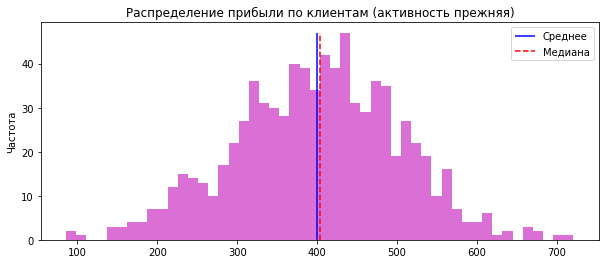

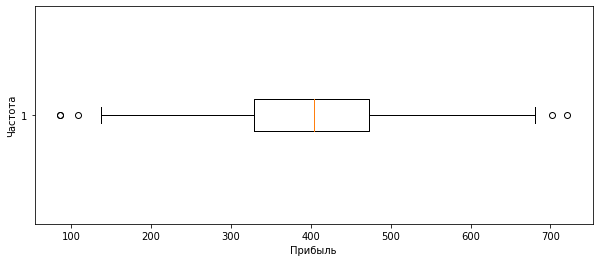

count    802.000000
mean     399.557357
std      103.261820
min       86.000000
25%      329.250000
50%      404.000000
75%      472.750000
max      721.000000
Name: profit, dtype: float64

In [56]:
money_0 = market_file_0.merge(money, on='id', how='left')
money_1 = market_file_1.merge(money, on='id', how='left')
eda_number(money_1,
           'profit', 
           'Распределение прибыли по клиентам (активность снижена)', 
           'Прибыль', 'orchid'
          )

eda_number(money_0,
           'profit', 
           'Распределение прибыли по клиентам (активность прежняя)', 
           'Прибыль', 'orchid'
          )

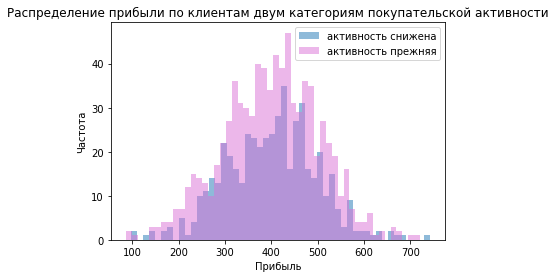

In [57]:
#визуализируем информацию о прибыли для пользователей обеих категорий
plt.hist(money_1['profit'], bins=50, alpha=0.5, label='активность снижена')
plt.hist(money_0['profit'], bins=50, alpha=0.5, color="orchid", label='активность прежняя')
# Добавление подписей осей
plt.xlabel('Прибыль')
plt.ylabel('Частота')
plt.title('Распределение прибыли по клиентам двум категориям покупательской активности')
plt.legend()
plt.show()

Прибыль в разрезе активности покупателя находится примерно на одном уровне. Среднемесячная прибыль с покупателя около 400

### Отберите клиентов с покупательской активностью не менее трёх месяцев, то есть таких, которые что-либо покупали в этот период. 

In [58]:
market_money = market_money[market_money['revenue']>0] 
market_money.shape

(3893, 3)

Сделаем замеры получившихся датасетов

In [59]:
#сделаем замер исходных датасетовпосле удаления пропусков, дубликатов, выбросов
print('% от исходных данных о поведении покупателя на сайте - market_file:',
      len(market_file)/len(temp0_market_file))

print('% от исходных данных о выручке, которую получает магазин с покупателя за период - market_money:', 
      len(market_money)/len(temp0_market_money))

print('% от исходных данных  о времени (в минутах), которое покупатель провёл на сайте в течение периода - market_time:',
      len(market_time)/len(temp0_market_time))

print('% от исходных данных о среднемесячной прибыли покупателя за последние 3 месяца - money:',
      len(money)/len(temp0_money))

% от исходных данных о поведении покупателя на сайте - market_file: 1.0
% от исходных данных о выручке, которую получает магазин с покупателя за период - market_money: 0.9982051282051282
% от исходных данных  о времени (в минутах), которое покупатель провёл на сайте в течение периода - market_time: 1.0
% от исходных данных о среднемесячной прибыли покупателя за последние 3 месяца - money: 1.0


Количество исходных данных почти не изменилось . удалось сохранить почти 100% данных.

### Оформите выводы по результатам шага

На данном этапе проведен исследовательский анализ числовых и категориальных признаков. В целом данные распределены нормально. В некоторых столбцах присутствовало небольшое количесво выбросов, от которых получилось избавиться.

По итогам исследовательского анализа можно составить портрет покупателя со сниженной покупательской активностью. 
- по поведению на сайте 

Заметно снижение покупательской активности на меньших оборотах маркетинговых коммуникаций. Отток пользователей происходит независимо от того сколько дней они зарегистрированы на сайте.   

Покупатели со сниженной активностью чаще оставляют больше неопалаченных товаров в корзине.


Покупатели с прежней активностью чаще сталкиваются с багами на сайте чем покупатели со сниженной активностью , потому что их просто больше.

Покупатели со сниженной активностью просматривают меньше категорий.  

Все пользователи просматривают от 1 до 20 страниц, но чаще 8, а пользователи со сниженной активностью просматриваю меньше страниц, в среднем 5 страниц. 

Пользователи со сниженной активностью проводят на сайте меньше минут чем  те, кто сохраняют свою активность.  
Для пользователей с разной активностью время проведенное на сайте за 2 месяца, практически не меняется и распределяется  50/50.  

- по продуктовому поведению 
29.32% оттока покупателей происходит из категории "товары для детей"- это самая большая категория по численности покупателей, 21.08% косметика и аксессуары, 20.48% домашний текстиль, 70.88 % оттока именно из этих категорий. 13.25% кухонная посуда - , 10.44% техника для красоты и здоровья, 5.42% мелкая бытовая техника.  

Для покупателей со снижающейся активностью: доля акционных товаров от 0 до  99%.  Медиана 31%, а среднее 45%, четверть покупателей в 89% покупок предпочтитают акционные товары.  Клиенты со снижающейся покупательской активностью , в своем "продуктовом портфеле" имеют бОльшую долю акционных товаров, чем те, кто сохраняют активность.  Это может свидетельствовать о том , что вся заинтересованность таких покупателей в данном магазине сводится к товарам по акции. 


  
  



- по финансовой стоставляющей

Выручка в обеих категориях покупателей примерно на одном уровне. Среднее значение около 5000. Выручка варьируется в пределах от 2759 - 7799 (медиана 4880) у покупателей со сниженной активностью, и от 2952 до 7548 (медиана 4990) у покупателей с прежней активностью. У покупателей со снижающейся активностью в течение 3 месяцев выручка с небольшим приростом , но стабильно растет. 

Прибыль в разрезе активности покупателя находится примерно на одном уровне. Среднемесячная прибыль с покупателя около 400 независимо от активности.

## Объединение таблиц

### Объедините таблицы market_file.csv, market_money.csv, market_time.csv. 

Данные о прибыли из файла money.csv при моделировании вам не понадобятся. 
Учитывайте, что данные о выручке и времени на сайте находятся в одном столбце для всех периодов. В итоговой таблице сделайте отдельный столбец для каждого периода.

In [60]:
#трансформируем таблицы market_money и market_time, так чтобы для каждого периода был отдельный столбец
pivot_market_money = market_money.pivot_table(index='id', values='revenue', columns='period_market_money', aggfunc='sum')
# Упрощаем заголовки
pivot_market_money.columns = ['revenue_two_month_ago', 'revenue_previous_month', 'revenue_current_month']
pivot_market_time = market_time.pivot_table(index='id', values='mins', columns='period_market_time', aggfunc='sum')
pivot_market_time.columns = ['mins_previous_month', 'mins_current_month']
#устанавливаем id индексом в датасете market_file
market_file = market_file.set_index('id')

In [61]:
print('market_file', market_file.shape)
print('pivot_market_money', pivot_market_money.shape)
print('pivot_market_time', pivot_market_time.shape)

market_file (1300, 12)
pivot_market_money (1300, 3)
pivot_market_time (1300, 2)


In [62]:
data = market_file.join(pivot_market_money, how='inner')
data = data.join(pivot_market_time, how='inner')
data.shape

(1300, 17)

In [64]:
data.head(2)

consumer_activity service_class offer_allow  advert_6_m  \
id                                                               
215348         снизилась       премиум          да         3.4   
215349         снизилась       премиум          да         4.4   

        advert_current_m  duration_days  promo_purchases  popular_category  \
id                                                                           
215348                 5            121             0.00  товары для детей   
215349                 4            819             0.75  товары для детей   

        avr_category_views  unpaid_pcs_left_bag_quarter  site_bugs  \
id                                                                   
215348                   6                            2          1   
215349                   4                            4          2   

        pages_per_visit_3m  revenue_two_month_ago  revenue_previous_month  \
id                                                                          
215348                   5                    NaN                     NaN   
215349                   5                 4472.0                  5216.0   

        revenue_current_month  mins_previous_month  mins_current_month  
id                                                                      
215348                 3293.1                   13                  14  
215349                 4971.6                   12                  10

### Оформите выводы по результатам шага

Объединили три датасета - market_file, market_money, market_time в один , итого общий датасет составил 1300 строк и 17 столбцов.

## Корреляционный анализ

### Проведите корреляционный анализ признаков в количественной шкале в итоговой таблице для моделирования. 

Изучим взаимосвязь между признаками: рассчитаем коэффициенты корреляции между всеми числовыми признаками.

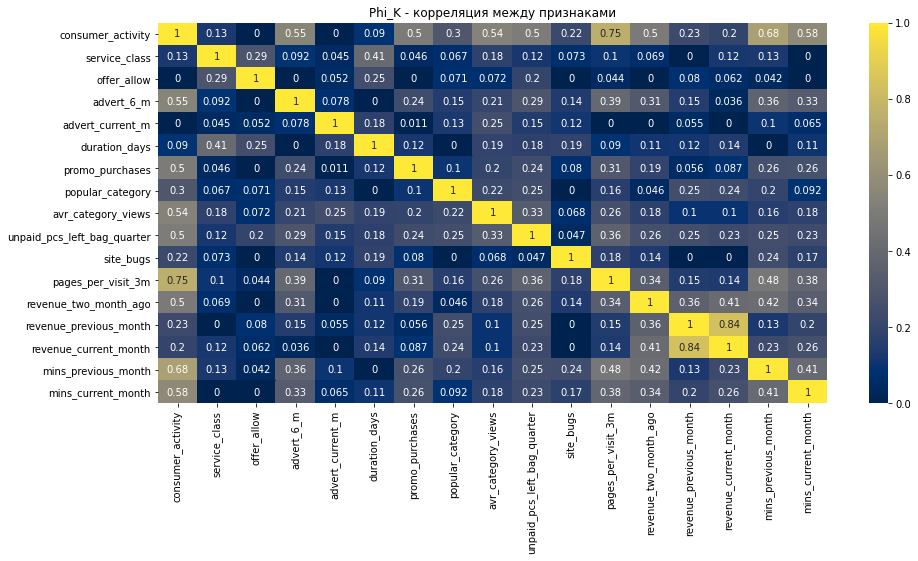

In [63]:
data_num = data.select_dtypes('number')
num_columns=data_num.columns.tolist()
corr_matrix = data.phik_matrix(interval_cols=num_columns)

# Визуализация матрицы корреляции
plt.figure(figsize=(15, 7))
sns.heatmap(corr_matrix, annot=True, cmap='cividis')
plt.title('Phi_K - корреляция между признаками')
plt.show();

Корреляция между числовыми признаками


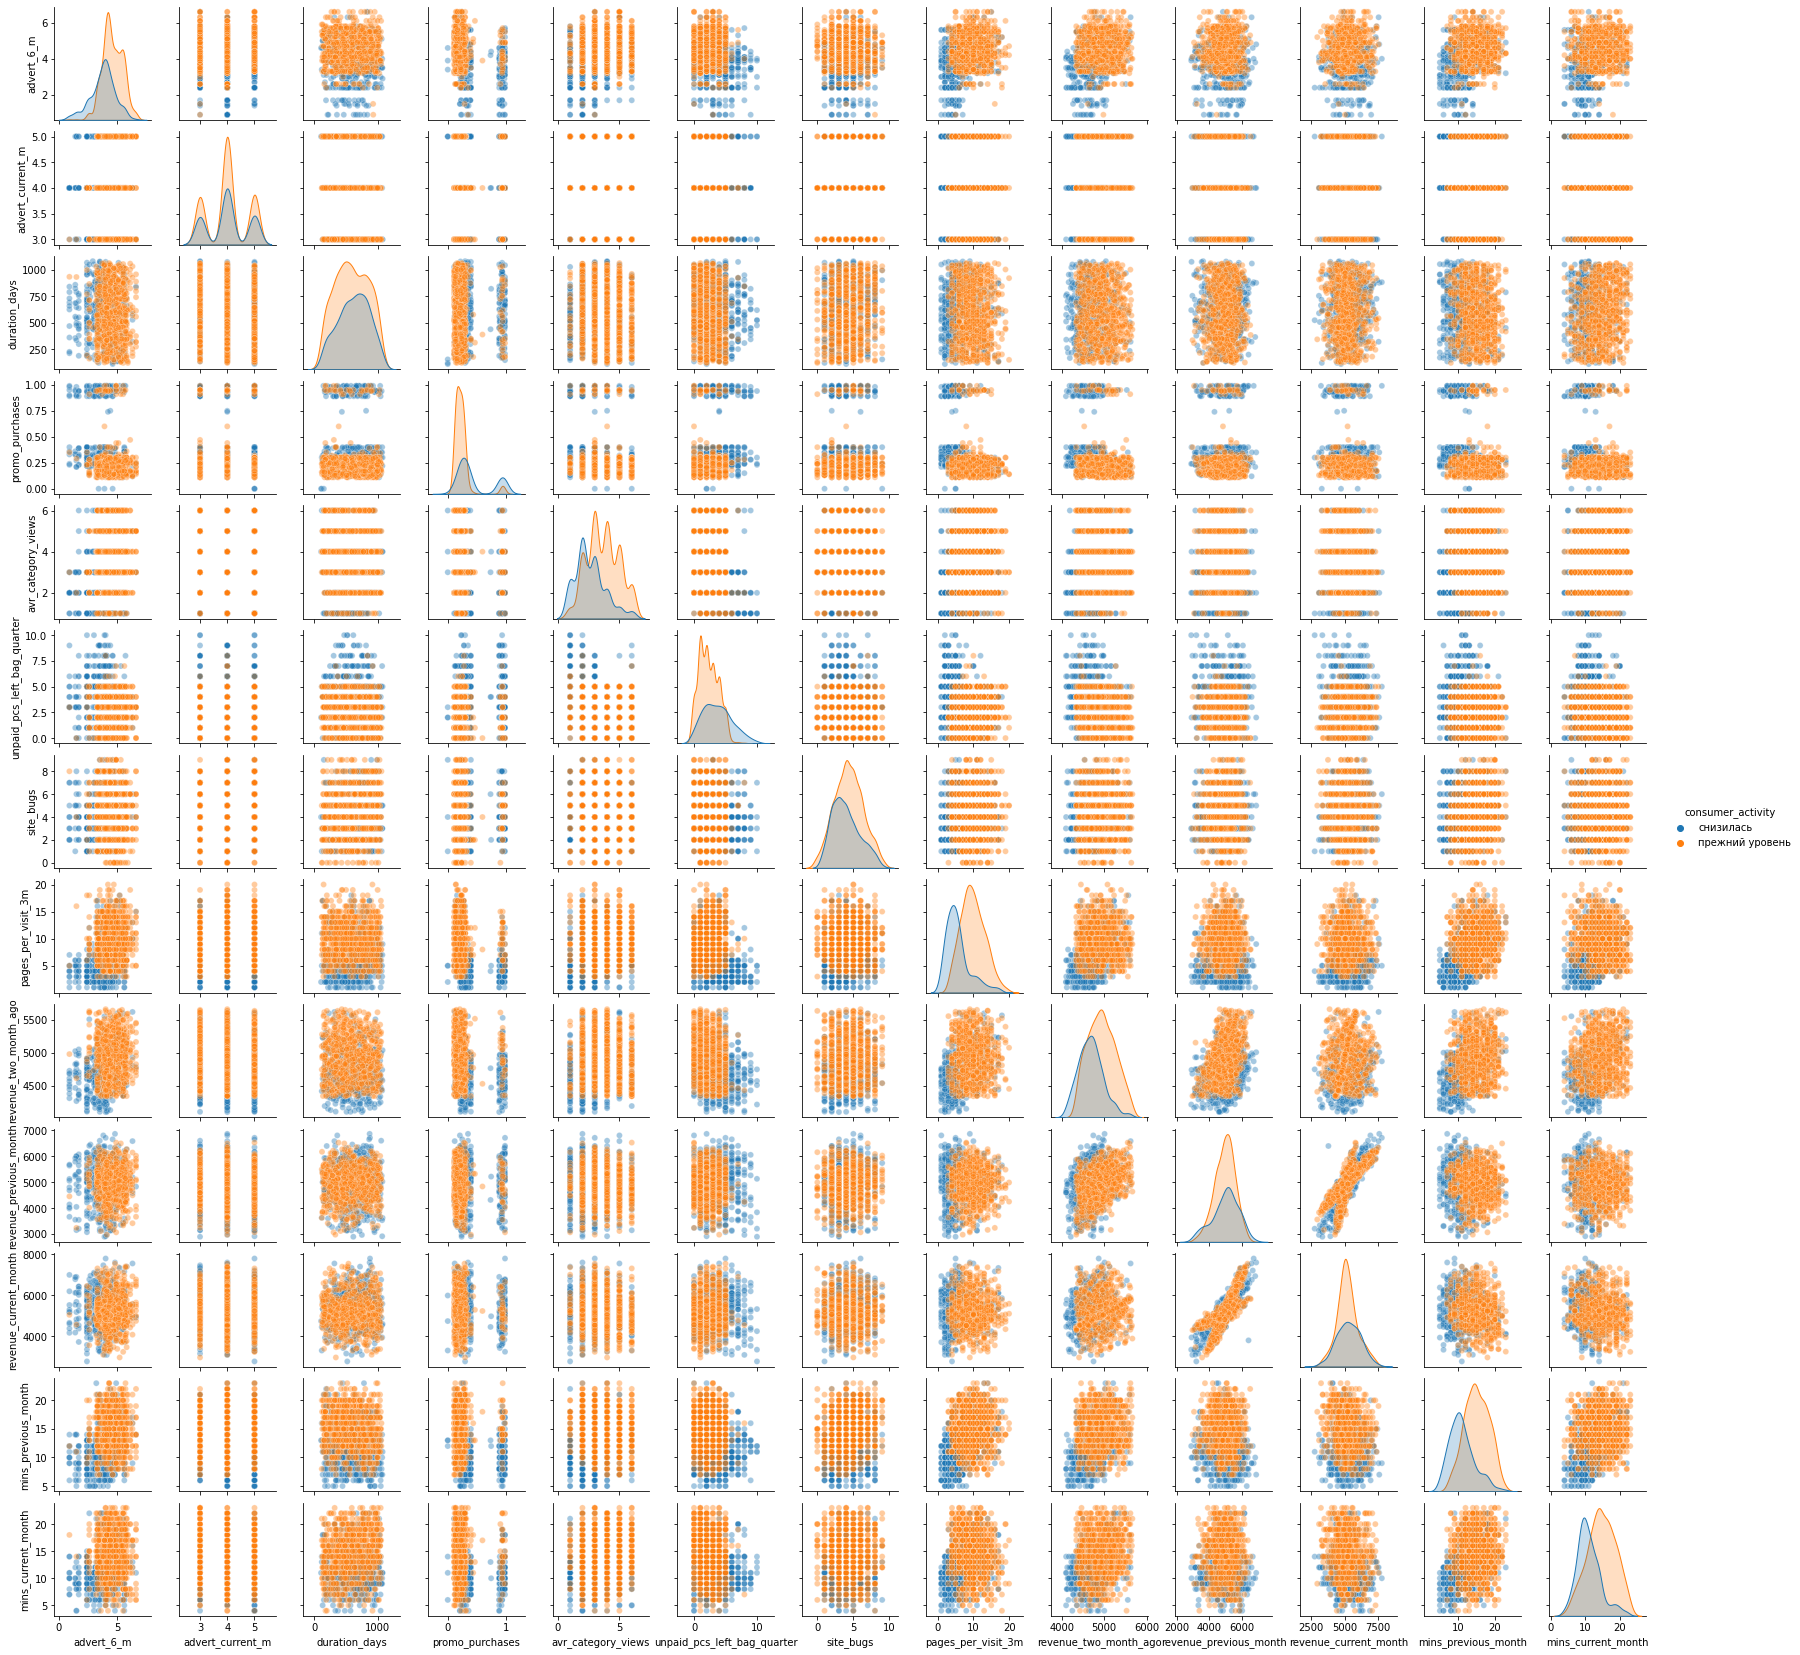

In [64]:
print('Корреляция между числовыми признаками')

_ = sns.pairplot(data, hue='consumer_activity', plot_kws={'alpha': 0.4}, height=1.8)

### Сделайте выводы о мультиколлинеарности и при необходимости устраните её.

Мультиколлинеарность принято учитывать при корреляции признаков выше 0.9, такой сильной зависимости в данных нет, поэтому для обучения модели на данном этапе не нужно было бы исключатб никакие признаки. Но наблюдаем силную зависимость по выручке за текущий и предыдущий месяц. при обучении модели не будем учитывать данные по выручке за текущий месяц, чтобы не было утечки данных 

### Оформите выводы по результатам шага

По матрице Phik наблюдаем, что у целевого признака (покупательская активность) есть сильная взаимосвязь с коммуникацияи за последние 6 месяцев, количеством просмотренных страниц, минутами проведенными на сайте, просмотренными категориями, и  товарами , купленными по промо акции.  

Среди входных признаков наблюдается положительная линейная связь только между данными по выручке, рост выручки мы отмечали ранее.  
 
Покупатели, у которых снизилась активность , стали оставлять больше товаров в корзине, проводить меньше времени на сайте и просматривать меньше страниц.  Возможно дело в багах. однозначно сказать нельзя, так как баги распределены равномерно для обеих категорий активности покупателей.  Скорее всего за счет промо товаров , более автивные продолжают делать покупки , а другие уходят с сайта, не закончив покупку. Так же первые позволяют получать больше рекламы чем вторые.



## Использование пайплайнов

### Подготовка данных
Во время подготовки данных используйте ColumnTransformer. Количественные и категориальные признаки обработайте в пайплайне раздельно. Для кодирования категориальных признаков используйте как минимум два кодировщика, для масштабирования количественных — как минимум два скейлера.
Напоминаем, что для каждой модели можно подготовить данные с разным кодированием и масштабированием.

In [65]:
data['consumer_activity'].value_counts()

прежний уровень    802
снизилась          498
Name: consumer_activity, dtype: int64

Так как в целевом признаке присутствует дисбаланс классов, то будет делать данные на выборки используя стратификацию. 

In [66]:
data['consumer_activity'] = data['consumer_activity'].apply(lambda x: 1 if x=='снизилась' else 0)
data

consumer_activity service_class offer_allow  advert_6_m  \
id                                                                
215348                  1       премиум          да         3.4   
215349                  1       премиум          да         4.4   
215350                  1      стандарт         нет         4.9   
215351                  1      стандарт          да         3.2   
215352                  1      стандарт         нет         5.1   
...                   ...           ...         ...         ...   
216643                  0      стандарт          да         6.6   
216644                  0      стандарт         нет         5.1   
216645                  0      стандарт          да         4.1   
216646                  0      стандарт          да         6.3   
216647                  0       премиум          да         4.0   

        advert_current_m  duration_days  promo_purchases  \
id                                                         
215348                 5            121             0.00   
215349                 4            819             0.75   
215350                 3            539             0.14   
215351                 5            896             0.99   
215352                 3           1064             0.94   
...                  ...            ...              ...   
216643                 3            318             0.24   
216644                 4            454             0.21   
216645                 3            586             0.20   
216646                 5            645             0.12   
216647                 5            906             0.94   

                      popular_category  avr_category_views  \
id                                                           
215348                товары для детей                   6   
215349                товары для детей                   4   
215350               домашний текстиль                   5   
215351                товары для детей                   5   
215352                товары для детей                   3   
...                                ...                 ...   
216643  техника для красоты и здоровья                   5   
216644               домашний текстиль                   6   
216645               домашний текстиль                   3   
216646  техника для красоты и здоровья                   3   
216647  техника для красоты и здоровья                   4   

        unpaid_pcs_left_bag_quarter  site_bugs  pages_per_visit_3m  \
id                                                                   
215348                            2          1                   5   
215349                            4          2                   5   
215350                            2          1                   5   
215351                            0          6                   4   
215352                            2          3                   2   
...                             ...        ...                 ...   
216643                            3          3                  11   
216644                            2          3                   9   
216645                            2          5                   7   
216646                            3          5                   7   
216647                            5          3                  12   

        revenue_two_month_ago  revenue_previous_month  revenue_current_month  \
id                                                                             
215348                    NaN                     NaN                 3293.1   
215349                 4472.0                  5216.0                 4971.6   
215350                 4826.0                  5457.5                 5058.4   
215351                 4793.0                  6158.0                 6610.4   
215352                 4594.0                  5807.5                 5872.5   
...                       ...                     ...                    ... 

In [67]:
data['consumer_activity'].value_counts()

0    802
1    498
Name: consumer_activity, dtype: int64

In [68]:
#разбиваем данные на тестовые и тренировочные выборки
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(['consumer_activity'], axis=1),
    data['consumer_activity'],
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=data['consumer_activity']
)

In [69]:
print('X_train', X_train.shape)
print('X_test', X_test.shape)
print('y_train', y_train.shape)
print('y_test', y_test.shape)

X_train (975, 16)
X_test (325, 16)
y_train (975,)
y_test (325,)


Разбивка на учебную и тестовые выборки прошла успешно. 

In [70]:
# создаём списки с названиями признаков
ohe_columns = data.select_dtypes(exclude='number').drop(['popular_category'], axis=1
).columns.tolist()

ord_columns = ['popular_category']

num_columns = data.select_dtypes(include='number').drop(['consumer_activity'], axis=1
).columns.tolist()

print('ohe_columns:', ohe_columns)
print('ord_colums:', ord_columns)
print('num_columns:', num_columns)

ohe_columns: ['service_class', 'offer_allow']
ord_colums: ['popular_category']
num_columns: ['advert_6_m', 'advert_current_m', 'duration_days', 'promo_purchases', 'avr_category_views', 'unpaid_pcs_left_bag_quarter', 'site_bugs', 'pages_per_visit_3m', 'revenue_two_month_ago', 'revenue_previous_month', 'revenue_current_month', 'mins_previous_month', 'mins_current_month']


In [71]:
# создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
# SimpleImputer + OHE
ohe_pipe = Pipeline(
    [
        ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ohe', OneHotEncoder(sparse=False, drop='first'))       
    ]
)

# Создаем пайплайн для подготовки признаков из списка ord_columns:
# 1) заполняем пропуски,
# 2) проводим Ordinal-кодирование
ord_pipe = Pipeline(
    [
        ('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        (
            'ord', OrdinalEncoder(
                handle_unknown='use_encoded_value',
                unknown_value=-1
            )
        ),
        ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))   
    ]
)
# Создаем пайплайн для подготовки признаков из списка num_columns:
# 1) заполняем пропуски медианой,
# 2) проводим масштабирование, Используем StandardScaler по умолчанию
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())  
])

data_preprocessor = ColumnTransformer(
        [
            ('ohe', ohe_pipe, ohe_columns),
            ('ord', ord_pipe, ord_columns),
            ('num', num_pipe, num_columns)
        ],
        remainder='passthrough'
    )


Данные подготовлены, можно переходить к обучению моделей. 

### Обучение моделей
Обучите четыре модели: KNeighborsClassifier(), DecisionTreeClassifier(), LogisticRegression() и  SVC(). Для каждой из них подберите как минимум один гиперпараметр. Выберите подходящую для задачи метрику, аргументируйте свой выбор. Используйте эту метрику при подборе гиперпараметров.

Для ценки модели была выбрана метрика - ROC AUC, ROC AUC оценивает работу модели более обобщённо, независимо от порога классификации, данная метрика часто используюется в задачах бинарной классификации.


ROC AUC оценивает способность модели различать классы, независимо от их распределения в данных. Это особенно полезно, когда в данных наблюдается дисбаланс.



**DecisionTreeClassifier**

In [72]:
#создаём полный пайплайн для модели  DecisionTreeClassifier
pipe_dtc = Pipeline([
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ])

#прописываем параметры перебора
#варианты масштабирования
#гиперпараметры модели DecisionTreeClassifier
param_distributions = {
    'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), RobustScaler()],  #указываем только название скейлера
    'models__max_depth': range(2, 7), #изменила гиперпараметр для экспериментов с Git
    'models__max_features': range(2, 7) #изменила гиперпараметр для экспериментов с Git
}
#перебор вариантов масштабирования и  гипермараметров модели
randomized_search = RandomizedSearchCV(
    pipe_dtc,
    param_distributions=param_distributions,
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)


#обучаем модель    
randomized_search.fit(X_train, y_train)
y_pred = randomized_search.predict(X_test)
y_pred_proba = randomized_search.predict_proba(X_test)[:, 1]
    

# Извлекаем лучший скейлер
best_scaler = randomized_search.best_estimator_.named_steps['preprocessor'].named_transformers_['num'].named_steps['scaler']
   
print('DecisionTreeClassifier и её параметры:\n\n', randomized_search.best_estimator_)
print('Лучший скейлер:', best_scaler)
print ('ROC-AUC на тренировочной выборке:', randomized_search.best_score_)
print('ROC-AUC на тестовой выборке:', roc_auc_score(y_test, y_pred_proba))


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)
/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.

DecisionTreeClassifier и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  ['service_class',
                                                   'offer_allow']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                        

/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


In [73]:
result_dtc = pd.DataFrame(randomized_search.cv_results_)
result_dtc['model'] = 'DecisionTreeClassifier'
result_dtc = result_dtc[result_dtc['mean_test_score'] == result_dtc['mean_test_score'].max()]

result = result_dtc


**KNeighborsClassifier**

In [74]:
#создаём полный пайплайн для модели  KNeighborsClassifier
pipe_knn = Pipeline([
        ('preprocessor', data_preprocessor),
        ('models', KNeighborsClassifier())
    ])

#прописываем параметры перебора
#варианты масштабирования
#гиперпараметры модели KNeighborsClassifier
param_distributions = {
    'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), RobustScaler()],  #указываем только название скейлера
    'models__n_neighbors': range(2, 20)
}
#перебор вариантов масштабирования и  гипермараметров модели
randomized_search_knn = RandomizedSearchCV(
    pipe_knn,
    param_distributions=param_distributions,
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

#чтобы не было красных предупреждений
with warnings.catch_warnings():
    warnings.simplefilter("ignore", FutureWarning)
#обучаем модель    
    randomized_search_knn.fit(X_train, y_train)
    y_pred = randomized_search_knn.predict(X_test)
    y_pred_proba = randomized_search_knn.predict_proba(X_test)[:, 1]
# Извлекаем лучший скейлер
best_scaler = randomized_search_knn.best_estimator_.named_steps['preprocessor'].named_transformers_['num'].named_steps['scaler']    
print('KNeighborsClassifier и её параметры:\n\n', randomized_search_knn.best_estimator_)
print('Лучший скейлер:', best_scaler)
print ('ROC-AUC на тренировочной выборке:', randomized_search_knn.best_score_)
print('ROC-AUC на тестовой выборке:', roc_auc_score(y_test, y_pred_proba))

KNeighborsClassifier и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  ['service_class',
                                                   'offer_allow']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                          

In [75]:
result_knn = pd.DataFrame(randomized_search_knn.cv_results_)
result_knn['model'] = 'KNeighborsClassifier'
result_knn = result_knn[result_knn['mean_test_score'] == result_knn['mean_test_score'].max()]

result = pd.concat([result, result_knn])


**LogisticRegression**

In [76]:
#создаём полный пайплайн для модели  LogisticRegression
pipe_logr = Pipeline([
        ('preprocessor', data_preprocessor),
        ('models', LogisticRegression(random_state=RANDOM_STATE,
                                      penalty='l2',
                                      max_iter=4000
                                     ))
    ])

#прописываем параметры перебора
#варианты масштабирования
#гиперпараметры модели LogisticRegression
param_distributions = {
    'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), RobustScaler()], #указываем только название скейлера
    'models__C': [0.1, 1, 10, 100],
    'models__solver': ['saga', 'liblinear']
}
#перебор вариантов масштабирования и  гипермараметров модели
randomized_search = RandomizedSearchCV(
    pipe_logr,
    param_distributions=param_distributions,
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

#чтобы не было красных предупреждений
with warnings.catch_warnings():
    warnings.simplefilter("ignore", FutureWarning)
#обучаем модель    
    randomized_search.fit(X_train, y_train)
    y_pred = randomized_search.predict(X_test)
    y_pred_proba = randomized_search.predict_proba(X_test)[:, 1]
# Извлекаем лучший скейлер
best_scaler = randomized_search.best_estimator_.named_steps['preprocessor'].named_transformers_['num'].named_steps['scaler']    
print('LogisticRegression и её параметры:\n\n', randomized_search.best_estimator_)
print('Лучший скейлер:', best_scaler)
print ('ROC-AUC на тренировочной выборке:', randomized_search.best_score_)
print('ROC-AUC на тестовой выборке:', roc_auc_score(y_test, y_pred_proba))

LogisticRegression и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  ['service_class',
                                                   'offer_allow']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                            

In [77]:
result_logr = pd.DataFrame(randomized_search.cv_results_)
result_logr['model'] = 'LogisticRegression'
result_logr = result_logr[result_logr['mean_test_score'] == result_logr['mean_test_score'].max()]

result = pd.concat([result, result_logr])

**SVC**

In [78]:
#создаём полный пайплайн для модели  SVC
pipe_svc = Pipeline([
        ('preprocessor', data_preprocessor),
        ('models', SVC(random_state=RANDOM_STATE, probability=True))
    ])

#прописываем параметры перебора
#варианты масштабирования
#гиперпараметры модели SVC
param_distributions = {
    'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), RobustScaler()], #указываем только название скейлера
    'models__kernel': ['rbf', 'sigmoid', 'poly'],
    'models__degree': [2, 3, 4]
}
#перебор вариантов масштабирования и  гипермараметров модели
randomized_search = RandomizedSearchCV(
    pipe_svc,
    param_distributions=param_distributions,
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

#чтобы не было красных предупреждений
with warnings.catch_warnings():
    warnings.simplefilter("ignore", FutureWarning)
#обучаем модель    
    randomized_search.fit(X_train, y_train)
    y_pred = randomized_search.predict(X_test)
    y_pred_proba = randomized_search.predict_proba(X_test)[:, 1]
# Извлекаем лучший скейлер
best_scaler = randomized_search.best_estimator_.named_steps['preprocessor'].named_transformers_['num'].named_steps['scaler']    
print('SVC и её параметры:\n\n', randomized_search.best_estimator_)
print('Лучший скейлер:', best_scaler)
print ('ROC-AUC на тренировочной выборке:', randomized_search.best_score_)
print('ROC-AUC на тестовой выборке:', roc_auc_score(y_test, y_pred_proba))

SVC и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  ['service_class',
                                                   'offer_allow']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleIm

In [79]:
result_svc = pd.DataFrame(randomized_search.cv_results_)
result_svc['model'] = 'SVC'
result_svc = result_svc[result_svc['mean_test_score'] == result_svc['mean_test_score'].max()]

result = pd.concat([result, result_svc])





### Выбор лучшей модели
Выберите лучшую модель, используя заданную метрику. Для этого примените одну из стратегий:
использовать пайплайны и инструменты подбора гиперпараметров для каждой модели отдельно, чтобы выбрать лучшую модель самостоятельно;
использовать один общий пайплайн для всех моделей и инструмент подбора гиперпараметров, который вернёт вам лучшую модель

In [80]:
result.sort_values('mean_test_score')

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
3       0.015739      0.000787         0.006860        0.000160   
7       0.020833      0.000488         0.007181        0.000093   
2       0.137228      0.036023         0.011865        0.000367   
2       0.063915      0.001754         0.010623        0.000641   
4       0.064699      0.001625         0.010531        0.000430   

  param_preprocessor__num__scaler param_models__max_features  \
3                  MinMaxScaler()                          4   
7                  MinMaxScaler()                        NaN   
2                StandardScaler()                        NaN   
2                StandardScaler()                        NaN   
4                StandardScaler()                        NaN   

  param_models__max_depth                                             params  \
3                       5  {'preprocessor__num__scaler': MinMaxScaler(), ...   
7                     NaN  {'preprocessor__num__scaler': MinMaxScaler(), ...   
2                     NaN  {'preprocessor__num__scaler': StandardScaler()...   
2                     NaN  {'preprocessor__num__scaler': StandardScaler()...   
4                     NaN  {'preprocessor__num__scaler': StandardScaler()...   

   split0_test_score  split1_test_score  ...  split4_test_score  \
3           0.838444           0.804500  ...           0.845935   
7           0.919111           0.876000  ...           0.910208   
2           0.929056           0.873611  ...           0.943601   
2           0.936111           0.908667  ...           0.929864   
4           0.936111           0.908667  ...           0.929864   

   mean_test_score  std_test_score  rank_test_score                   model  \
3         0.833854        0.017282                1  DecisionTreeClassifier   
7         0.901553        0.019351                1      LogisticRegression   
2         0.912698        0.024020                1    KNeighborsClassifier   
2         0.920884        0.013160                1                     SVC   
4         0.920884        0.013160                1                     SVC   

   param_models__n_neighbors param_models__solver param_models__C  \
3                        NaN                  NaN             NaN   
7                        NaN                 saga             0.1   
2                         18                  NaN             NaN   
2                        NaN                  NaN             NaN   
4                        NaN                  NaN             NaN   

  param_models__kernel param_models__degree  
3                  NaN                  NaN  
7                  NaN                  NaN  
2                  NaN                  NaN  
2                  rbf                    3  
4                  rbf                    2  

[5 rows x 22 columns]

Лучшей моделью является KNeighborsClassifier с параметром n_neighbors = 18, scaler = StandardScaler()  

ROC-AUC на тестовой выборке: 0.9092842240410849

Поэтому за лучшую модель примем `randomized_search_knn.best_estimator_`

### Оформите выводы по результатам шага

На данном этапе были  использованы пайплайны и инструменты подбора гиперпараметров для каждой модели отдельно, всего обучалось 4 модели - KNeighborsClassifier(), DecisionTreeClassifier(), LogisticRegression() и  SVC(), для каждой из них перебирались  гипермараметры 3 метода масштабирования.  

Для ценки модели была выбрана  метрика   - roc_auc, так как данная метрика часто используюется в задачах бинарной классификации.  

Лучшей моделью признана KNeighborsClassifier с параметром n_neighbors = 18, scaler = StandardScaler(), метрика ROC-AUC на тестовой выборке: 0.9092842240410849

## Анализ важности признаков

### Оценим важность признаков для лучшей модели и построим график важности с помощью метода SHAP. 

In [81]:
# Получаем лучший пайплайн из RandomizedSearchCV
best_model = randomized_search_knn.best_estimator_
print(best_model)

# Преобразуем данные
X_train_scaled = best_model.named_steps['preprocessor'].transform(X_train)
X_test_scaled = best_model.named_steps['preprocessor'].transform(X_test)





# Сравниваем формы
print("Исходная форма:", X_train.shape)
print("После предобработки:", X_test_scaled.shape)

# Извлечение имен признаков
feature_names = []
for name, transformer, columns in data_preprocessor.transformers:
    if hasattr(transformer, 'get_feature_names_out'):
        feature_names.extend(transformer.get_feature_names_out(columns))
    else:
        feature_names.extend(columns)

print("Имена признаков после предобработки:", feature_names)



Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  ['service_class',
                                                   'offer_allow']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleImputer(strategy='most_f

/opt/conda/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


  0%|          | 0/80 [00:00<?, ?it/s]

/opt/conda/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/opt/conda/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to Tr

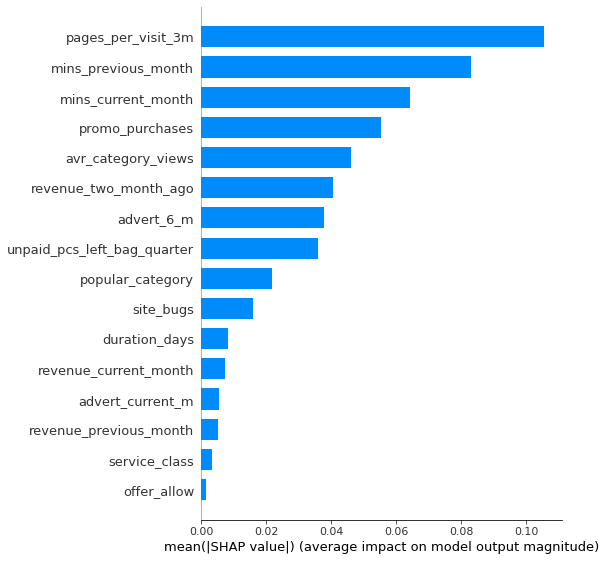

In [82]:
X_train_preprocessed = pd.DataFrame(X_train_scaled, columns=feature_names)
X_test_preprocessed = pd.DataFrame(X_test_scaled, columns=feature_names)

with warnings.catch_warnings():
    warnings.simplefilter("ignore", FutureWarning)


# Уменьшаем размер данных для ускорения работы KernelExplainer
X_train_sampled = shap.sample(X_train_preprocessed, 80, random_state=RANDOM_STATE)
X_test_sampled = shap.sample(X_test_preprocessed, 80, random_state=RANDOM_STATE)

# Создаем объяснитель SHAP
explainer = shap.KernelExplainer(best_model.named_steps['models'].predict, X_train_sampled)

# Рассчитываем значения SHAP для подмножества тестовых данных
shap_values = explainer.shap_values(X_test_sampled)

# Построим график важности признаков
shap.summary_plot(shap_values, X_test_sampled, plot_type='bar')

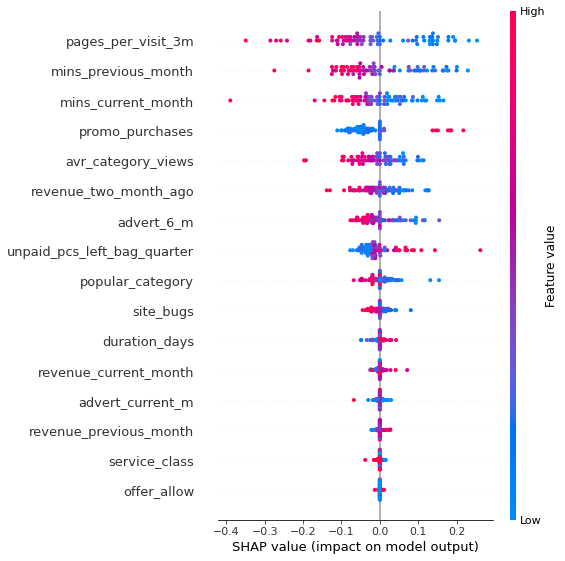

In [83]:
shap.summary_plot(shap_values, X_test_sampled)

### Сделайте выводы о значимости признаков  

Признаки мало значимые для модели: 

- Информация о том, можно ли присылать покупателю дополнительные предложения о товаре
- Тип сервиса
- Маркетинговые коммуникации за текущий месяц
- Выручка за предыдущий месяц




Признаки сильнее всего влияют на целевой признак:
- количество страниц за визит
- время, проведенное на сайте в текущем и предыдущем месяцах
- доля покупок по промоакции
- среднее количество просмотренныех категорий за визит
- выручка за позапрошлый месяц
- маркетинговые коммуникации за 6 месяцев
- неоплаченные продукты в корзине



### Оформите выводы по результатам шага

В предыдущем шаге выявили признаки, которые наиболее и наименее значимы для модели. 
SHAP анализ так же позволяет спрогнозировать как изменится покупательская активность при измененеии некоторых признаков. 
Покупательская активность снизится, если снизится интерес покупателя к магазину. С оттоком покупателей коррелирует следующее поведение признаков:
- снижение количества просмотренных страниц;
- снижение времени, проведенного на сайте;
- снижение среднего количества просматриваемых категорий за визит;
- снижение количества маркетинговых коммуникаций;
- увеличение количества неоплаченных продуктов в корзине;
- увеличится доля покупок товаров по акции.

Сравнение выше перечисленных признаков с портретом уходящего покупателя, составленным при проведении Исследовательского анализа данных (шаг 3):
- все пользователи просматривают от 1 до 20 страниц, но чаще 8, а пользователи со сниженной активностью действительно просматриваю меньше страниц, в среднем 5 страниц;  
- пользователи со сниженной активностью проводят на сайте меньше минут чем  те, кто сохраняют свою активность;
- покупатели со сниженной активностью просматривают меньше категорий;
- заметно снижение покупательской активности на меньших оборотах маркетинговых коммуникаций
- покупатели со сниженной активностью действительно чаще других оставляют больше неопалаченных товаров в корзине;  
- клиенты со снижающейся покупательской активностью в своем "продуктовом портфеле" имеют бОльшую долю акционных товаров, чем клиенты с прежней активностью.

## Сегментация покупателей

### Выполните сегментацию покупателей.
Используйте результаты моделирования и данные о прибыльности покупателей.

Добавим в основной датасет данные по среднемесячной прибыли покупателей, а также добавим прогнозное значение  


In [84]:
data_for_segment = X_test.join(money, how='inner')

#используем лучшую модель для добавления прогнозного значения 
data_for_segment['predictions_05'] = best_model.predict(X_test)
data_for_segment

/opt/conda/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


service_class offer_allow  advert_6_m  advert_current_m  duration_days  \
id                                                                              
216161      стандарт          да         4.1                 4            606   
215466       премиум         нет         2.4                 5            523   
216307       премиум          да         3.3                 4            488   
215710       премиум          да         3.5                 3            658   
215497       премиум          да         5.6                 5            719   
...              ...         ...         ...               ...            ...   
215565      стандарт         нет         2.4                 4            522   
216233       премиум          да         3.9                 4           1048   
215501       премиум          да         3.5                 3           1057   
216141      стандарт         нет         4.0                 4            748   
215395       премиум          да         1.5                 5            645   

        promo_purchases                      popular_category  \
id                                                              
216161             0.15        техника для красоты и здоровья   
215466             0.30        техника для красоты и здоровья   
216307             0.13                     домашний текстиль   
215710             0.98                      товары для детей   
215497             0.28  мелкая бытовая техника и электроника   
...                 ...                                   ...   
215565             0.99                       кухонная посуда   
216233             0.21        техника для красоты и здоровья   
215501             0.35                     домашний текстиль   
216141             0.28                 косметика и аксесуары   
215395             0.27                      товары для детей   

        avr_category_views  unpaid_pcs_left_bag_quarter  site_bugs  \
id                                                                   
216161                   6                            1          4   
215466                   1                           10          1   
216307                   4                            2          8   
215710                   3                            0          2   
215497                   1                            2          7   
...                    ...                          ...        ...   
215565                   2                            5          4   
216233                   3                            0          6   
215501                   4                            3          5   
216141                   4                            0          4   
215395                   3                            3          6   

        pages_per_visit_3m  revenue_two_month_ago  revenue_previous_month  \
id                                                                          
216161                  12                 4912.0                  3973.0   
215466                   4                 4748.0                  3202.0   
216307                  10                 4565.0                  5444.0   
215710                   5                 4402.0                  4052.0   
215497                   1                 4475.0                  5871.5   
...                    ...                    ...                     ...   
215565                   4                 4492.0                  4657.0   
216233                  14                 4553.0                  4325.0   
215501                   6                 4993.0                  6604.0   
216141                   9                 4885.0                  5660.5   
215395                   5                 4972.0                  5297.5   

        revenue_current_month  mins_previous_month  mins_current_month  \
id                                                                       
216161                 3289.2                 

### Выберите группу покупателей и предложите, как увеличить её покупательскую активность.
Проведите графическое и аналитическое исследование группы покупателей.
Сделайте предложения по работе с сегментом для увеличения покупательской активности.

Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.  

По портрету уходящего покупателя выяснили , что наиболее явно на отток покупателей влияют признаки, связанные с поведением пользователей на сайте.

Сегментируем покупателей по их поведению на сайте.  

Для этого сделаем срез данных по следующим признакам:
- `pages_per_visit_3m`         - количество страниц за визит
- `mins_previous_month`        - время, проведенное на сайте в предыдущем месяце 
- `mins_current_month`         - время, проведенное на сайте в текущем месяце 
- `avr_category_views`         - среднее количество просмотренныех категорий за визит 
- `promo_purchases`            - доля покупок по акции от общего числа покупок
- `profit`                     - среднемесячная прибыль
- `customer_activity_forecast` - прогноз модели о покупательской аткивности. 1 - снизится, 0 - останется на прежнем уровне



Корреляция между числовыми признаками


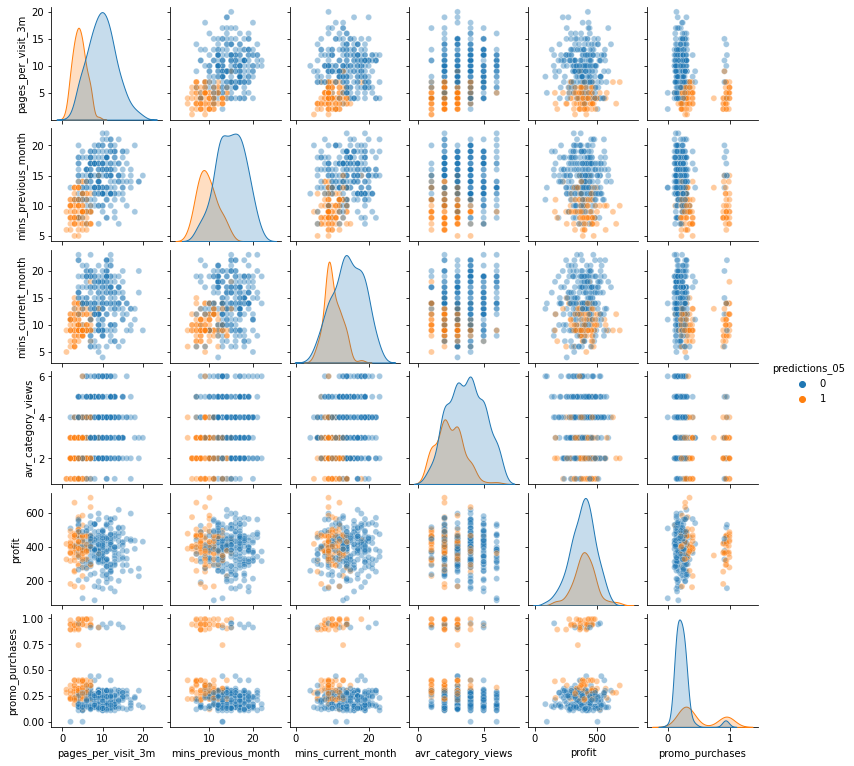

In [86]:
print('Корреляция между числовыми признаками')

_ = sns.pairplot(data_for_segment[['pages_per_visit_3m',
                            'mins_previous_month',
                            'mins_current_month',
                            'avr_category_views',
                            'profit',
                            'promo_purchases',
                            'predictions_05',
                           ]],
                 hue='predictions_05', plot_kws={'alpha': 0.4}, height=1.8)

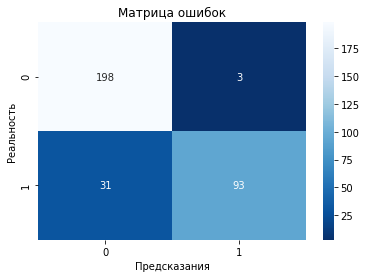

In [87]:
# построим матрицу ошибок и сохраните её в переменную
y_pred = data_for_segment['predictions_05'] 
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')
plt.title('Матрица ошибок')
plt.ylabel('Реальность')
plt.xlabel('Предсказания');

 Модель часто ошибается , предсказывая 0 , там , где 1, то есть нам нужно сменить порог вероятности , тем самым минимизировав ошибки типа FN, учвеличив recall.  
 Посчитаем прибыль взависимости от порога (название столбца profit_lost_fn_), которую можем потерять из-за ошибок в предсказании (ошибки FN). Это такие ошибки, когда модель предскажет , что клиент останется , мы не предпримем никаких действий, а он уйдет. 

In [88]:
y_proba = best_model.predict_proba(X_test)[:,1]
df = pd.DataFrame(zip(y_test, y_proba, data_for_segment.index, data_for_segment['profit']),
columns = ['y_test', 'y_proba', 'id', 'profit']).sort_values(by='y_proba',ascending=False) 
thresholds = [round(i,2) for i in np.linspace(0.1,0.55, num = 9,endpoint=False)]

# создаём переменную, которая будет хранить список новых колонок
columns = []

# добавляем столбцы с новыми предсказаниями в таблицу
for i in thresholds:
    columns.append('y_pred_'+str(i))
    df['y_pred_'+str(i)] = df['y_proba'].apply(lambda x: 1 if x > i else 0 )
    columns.append('fp_'+str(i))
    df['fp_'+str(i)] = df['y_pred_'+str(i)] - df['y_test']
    df.loc[df['fp_'+str(i)] < 0, 'fp_'+str(i)] = 0
    columns.append('fn_'+str(i))
    df['fn_'+str(i)] = df['y_test'] - df['y_pred_'+str(i)]
    df.loc[df['fn_'+str(i)] < 0, 'fn_'+str(i)] = 0
    columns.append('profit_'+str(i))
    df['profit_lost_fn_'+str(i)] = df['fn_'+str(i)] * df['profit']

In [89]:
# Применим выбранный порог
metrics = pd.DataFrame(columns=['threshold', 'roc_auc', 'recall', 'precision', 'fp', 'fn', 'profit_lost_fn_'])
for threshold in thresholds:
    y_pred = (y_proba >= threshold).astype(int)
    roc_auc = roc_auc_score(y_test, y_proba)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    fp = df['fp_'+str(threshold)].sum()
    fn = df['fn_'+str(threshold)].sum()
    profit_lost_fn_ = df['profit_lost_fn_'+str(threshold)].sum()
    metrics = metrics.append({
        'threshold': threshold,
        'roc_auc': roc_auc,
        'recall': recall,
        'precision': precision,
        'fp': fp,
        'fn': fn,
        'profit_lost_fn_': profit_lost_fn_
    }, ignore_index=True)

metrics


threshold   roc_auc    recall  precision     fp    fn  profit_lost_fn_
0       0.10  0.909284  0.935484   0.477366  127.0   8.0           3306.0
1       0.15  0.909284  0.903226   0.565657   86.0  12.0           5107.0
2       0.20  0.909284  0.862903   0.648485   58.0  17.0           7210.0
3       0.25  0.909284  0.854839   0.779412   30.0  18.0           7469.0
4       0.30  0.909284  0.798387   0.831933   20.0  25.0          10057.0
5       0.35  0.909284  0.782258   0.873874   14.0  27.0          11000.0
6       0.40  0.909284  0.782258   0.915094    9.0  27.0          11000.0
7       0.45  0.909284  0.766129   0.950000    5.0  29.0          11549.0
8       0.50  0.909284  0.766129   0.950000    3.0  31.0          12250.0

Остановимся на пороге 0.25, так как precision  не такой низкий еще. нужно поймать баланс, так как за каждую ошибку FP заказчику придется впустую потратить на стимулирование спроса клиентов, которые и так не собрались снижать спрос. 

Recall: 0.8548387096774194
Precision: 0.7794117647058824


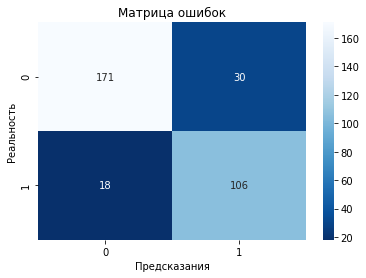

In [90]:
# Выбранный порог
threshold = 0.25

# Применение порога: если вероятность >= 0.72, то присваиваем класс 1
y_pred = (y_proba >= threshold).astype(int)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
print('Recall:', recall)
print('Precision:', precision)

# построим матрицу ошибок и сохраните её в переменную
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')
plt.title('Матрица ошибок')
plt.ylabel('Реальность')
plt.xlabel('Предсказания');

In [91]:
#заменим предсказания в таблице data_for_segment
data_for_segment['predictions_025'] = y_pred
print('было предсказаний класса 1 с порогом 0.5:', data_for_segment['predictions_05'].sum())
print('стало предсказаний класса 1 с порогом 0.25:', data_for_segment['predictions_025'].sum())

было предсказаний класса 1 с порогом 0.5: 96
стало предсказаний класса 1 с порогом 0.25: 136


In [92]:
data_for_segment['revenue_delta_last'] = data_for_segment['revenue_previous_month'] - data_for_segment['revenue_two_month_ago']
data_for_segment['revenue_delta_current'] = data_for_segment['revenue_current_month'] - data_for_segment['revenue_previous_month']

Так как мы рассматриваем покупателей с точки зрения их поведения на сайте, то выделим сегмент по количеству посещаемых страниц и среднему количеству категорий, просмотренных за визит (avr_category_views)

In [93]:
#определеям сегмент по спрогнозированному классу =1
segment = data_for_segment.query('(predictions_025==1) and (avr_category_views <= 4) and (pages_per_visit_3m <=7)') 

segment.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 106 entries, 215466 to 215395
Data columns (total 21 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   service_class                106 non-null    object 
 1   offer_allow                  106 non-null    object 
 2   advert_6_m                   106 non-null    float64
 3   advert_current_m             106 non-null    int64  
 4   duration_days                106 non-null    int64  
 5   promo_purchases              106 non-null    float64
 6   popular_category             106 non-null    object 
 7   avr_category_views           106 non-null    int64  
 8   unpaid_pcs_left_bag_quarter  106 non-null    int64  
 9   site_bugs                    106 non-null    int64  
 10  pages_per_visit_3m           106 non-null    int64  
 11  revenue_two_month_ago        106 non-null    float64
 12  revenue_previous_month       106 non-null    float64
 13  revenue_curr

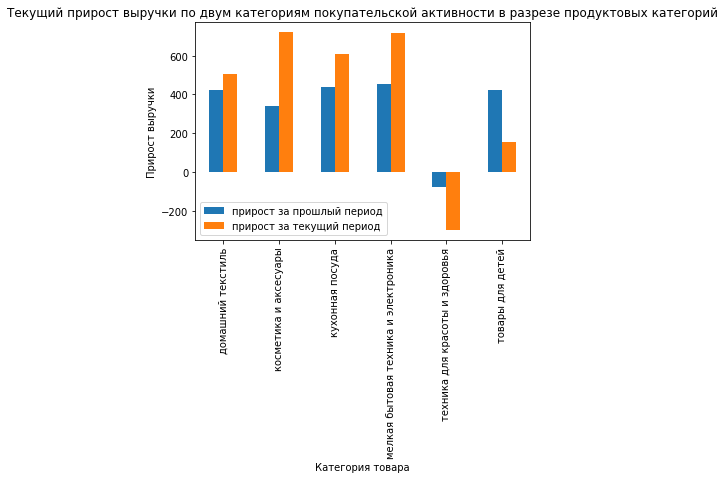

In [94]:
segment.pivot_table(
    index='popular_category',
    values = ['revenue_delta_current', 'revenue_delta_last'],  
    aggfunc='mean').plot(kind='bar',
                         y=['revenue_delta_current', 'revenue_delta_last'],
                        label = ['прирост за прошлый период', 'прирост за текущий период'])
# Добавление подписей осей
plt.xlabel('Категория товара')
plt.ylabel('Прирост выручки')
plt.title('Текущий прирост выручки по двум категориям покупательской активности в разрезе продуктовых категорий')
plt.legend()
plt.show()



Как и ранее обозначили в исследовательском анализе, выручка покупателей практически не проседает, в целом есть прирост  за счет роста выручки по всем категориям кроме техники для здоровья и красоты , товаров для детей. На эти точки можно воздействовать путем выдачи промокодов постоянным покупателям.

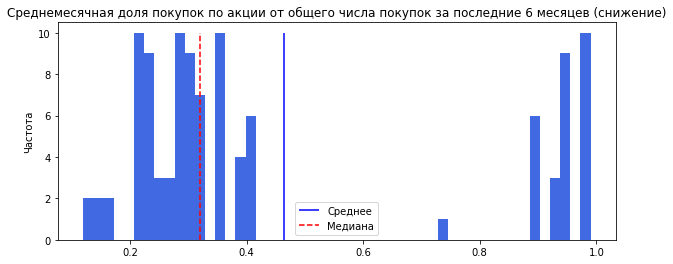

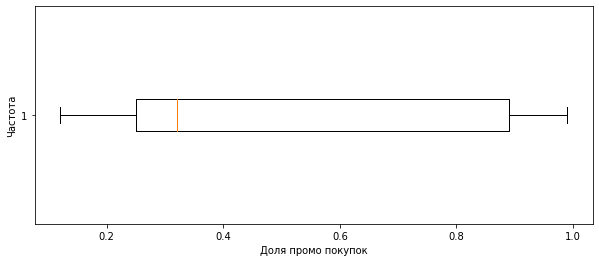

count    106.000000
mean       0.464340
std        0.299778
min        0.120000
25%        0.250000
50%        0.320000
75%        0.890000
max        0.990000
Name: promo_purchases, dtype: float64

In [95]:
eda_number(segment,
           'promo_purchases', 
           'Среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев (снижение)', 
           'Доля промо покупок', 'royalblue')

25% покупателей из выбранного сегмента в своей продуктовой корзине имеют от 89-99% акционных товаров. Чтобы не потерять таких покупателей  нужно постоянно обновлять линию товаров по акции. Посмотрим покупатели каких категорий приходят в магазин купить акционные товары.

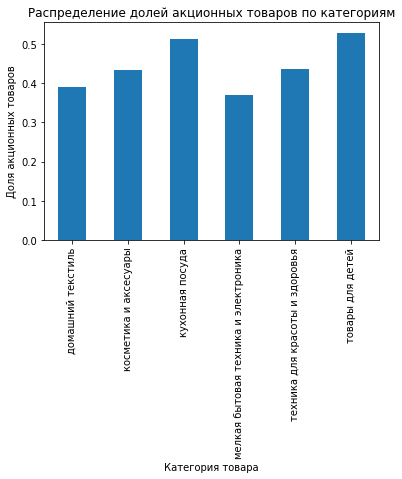

In [107]:
segment.pivot_table(
    index='popular_category',
    values = ['promo_purchases'],  
    aggfunc='mean').plot(kind='bar', legend=False
            )
# Добавление подписей осей
plt.xlabel('Категория товара')
plt.ylabel('Доля акционных товаров')
plt.title('Распределение долей акционных товаров по категориям')

plt.show()

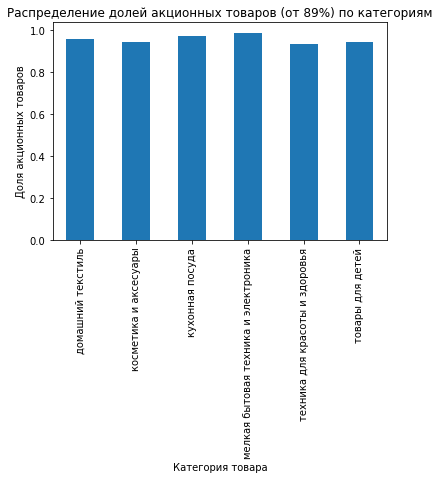

In [106]:
#выделим только те 25% , у которых в портцеле от 89% акционных товаров

segment.query('promo_purchases>0.89').pivot_table(
    index='popular_category',
    values = ['promo_purchases'],  
    aggfunc='mean').plot(kind='bar', legend=False
            )
# Добавление подписей осей
plt.xlabel('Категория товара')
plt.ylabel('Доля акционных товаров')
plt.title('Распределение долей акционных товаров (от 89%) по категориям')
plt.show()

В каждой категории есть любители тольео товаров по акции. Это действенный способ не дать таким клиентам уйти.

Ниже приведен сегмент покупателей из тестовой выборки, промокоды которым необходимо отправить в первую очередь:

In [98]:
segment.query('(popular_category == "техника для красоты и здоровья") or (popular_category == "товары для детей")')

service_class offer_allow  advert_6_m  advert_current_m  duration_days  \
id                                                                              
215466       премиум         нет         2.4                 5            523   
215710       премиум          да         3.5                 3            658   
215639       премиум          да         2.7                 5            845   
215480       премиум          да         4.4                 4            875   
215586       премиум          да         4.1                 4            557   
215716      стандарт          да         2.4                 4            952   
215611      стандарт          да         3.9                 3            519   
215369      стандарт         нет         2.7                 4            607   
215373       премиум         нет         3.8                 3            811   
215746       премиум          да         4.4                 4            987   
215403       премиум          да         1.7                 5            771   
215439       премиум         нет         3.4                 5            448   
215417       премиум          да         4.1                 5            377   
215361      стандарт          да         5.1                 4            199   
215527       премиум          да         4.1                 5            957   
215393      стандарт         нет         4.6                 4            169   
215507      стандарт          да         3.8                 3            871   
215375       премиум          да         3.0                 4            558   
215433      стандарт          да         4.0                 4            753   
215641       премиум          да         4.1                 4            666   
215394      стандарт          да         3.0                 5            966   
215702      стандарт         нет         1.7                 4            188   
215697       премиум          да         3.9                 4            935   
215829      стандарт          да         4.9                 4            600   
215647      стандарт          да         3.9                 5            529   
215539      стандарт          да         2.4                 4            953   
215659      стандарт         нет         1.4                 3            822   
215636      стандарт          да         3.5                 5            749   
215662      стандарт          да         2.9                 3            441   
216529      стандарт         нет         3.5                 3            757   
216252       премиум          да         4.3                 3           1036   
215352      стандарт         нет         5.1                 3           1064   
215549       премиум          да         2.6                 3            683   
215534       премиум         нет         4.0                 4            419   
216492      стандарт          да         4.0                 5            742   
215741      стандарт          да         4.8                 4            563   
215440      стандарт         нет         3.8                 5            344   
215666      стандарт          да         3.5                 5            703   
215395       премиум          да         1.5                 5            645   

        promo_purchases                popular_category  avr_category_views  \
id                                                                            
215466             0.30  техника для красоты и здоровья                   1   
215710             0.98                товары для детей                   3   
215639             0.32                товары для детей                   2   
215480             0.94                товары для детей                   2   
215586             0.94  техника для красоты и здоровья                   1   
215716             0.30  техника для красоты и здоровья                   3   
215611             0.40                товары для дет

### Сделайте выводы о сегментах
- какой сегмент вы взяли для дополнительного исследования,
- какие предложения вы сделали и почему.

Для проведения дополнительного анализа были рассмотрены покупатели по их поведению на сайте. Выявлено несколько закономерностей, покупательская активность снижается на потере интереса к сайту, когда покупатель покупает проводит меньше времени на сайте и просматривает . Некоторые  покупатели целенаправленно покупают только акционные товары, поэтому товары по акции могут быть хорошим инструментом для удержания таких клиентов.

В результате выполнения шага 8 выделен список покупателей, которым рекомендовано  раздать бонусы/промокоды на покупку популярной категории - товары для детей и мелкая бытовая техника для красоты.  


## Общий вывод

В ходе выполнения проекта необходимо было разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.
Для выполнения данной цели необходимо было построить модель, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца. 



В ходе проведения проекта, были изучены данные из четырез датасетов.
На этапе предобработки данных и исследовательского анализа  числовых и категориальных признаков было выявлено небольшое количество неявных дубликатов и выбросов, от которых удалось избавиться с наименьшими потерями в данных (менее 1%). В целом данные распределены нормально и также имеют распределение Пуассона. 

Далее с помощью матрицы Phik проведен корреляционный анализ данных.  У целевого признака (покупательская активность) есть сильная взаимосвязь с коммуникацияи за последние 6 месяцев, количеством просмотренных страниц, минутами проведенными на сайте, просмотренными категориями, и долей товаров, купленных по промо акции.
Покупатели, у которых снизилась активность , стали оставлять больше товаров в корзине, проводить меньше времени на сайте и просматривать меньше страниц. Мультиколинеарность не была обнаружена, во избежание утечки был удален столбец с вырукой за текущий месяц. 


Для решения задачи бинарной классификации использовалась  библеотека Pyhton scikit-learn и четыре классификатора:
- DecisionTreeClassifier (Классификатор на основе дерева решений)
- KNeighborsClassifier  (Классификатор на основе метода k ближайших соседей)
- LogisticRegression (Логистическая регрессия)
- SVC (Классификатор на основе метода опорных векторов)

Для поиска лучшей модели были использованы Пайплайны для подготовки данных к обучению (кодирование и масштабирование), а также перебор вариантов масштабирования (StandardScaler(), MinMaxScaler(), RobustScaler()) и гиперпараметров каждой модели с помощью RandomizedSearchCV.  

Лучшей моделью была признана: KNeighborsClassifier с параметром n_neighbors = 18, scaler = StandardScaler(),
метрика ROC-AUC на тестовой выборке: 0.9092842240410849

На основе полученных данных, используя  лучшую модель , был проведен анализ признаков с помощью библиотеки shap. 

Признаки мало значимые для модели:
- Информация о том, можно ли присылать покупателю дополнительные предложения о товаре
- Тип сервиса
- Маркетинговые коммуникации за текущий месяц
- Выручка за предыдущий месяц

Признаки сильнее всего влияют на целевой признак:
- количество страниц за визит
- время, проведенное на сайте в текущем и предыдущем месяцах
- доля покупок по промоакции
- среднее количество просмотренныех категорий за визит
- выручка за позапрошлый месяц
- маркетинговые коммуникации за 6 месяцев
- неоплаченные продукты в корзине


В предыдущем шаге выявили признаки, которые наиболее и наименее значимы для модели. SHAP анализ так же позволяет спрогнозировать как изменится покупательская активность при измененеии некоторых признаков. Покупательская активность снизится, если снизится интерес покупателя к магазину. С оттоком покупателей коррелирует следующее поведение признаков:

- снижение количества просмотренных страниц;
- снижение времени, проведенного на сайте;
- снижение среднего количества просматриваемых категорий за визит;
- снижение количества маркетинговых коммуникаций;
- увеличение количества неоплаченных продуктов в корзине;
- увеличится доля покупок товаров по акции.
Сравнение выше перечисленных признаков с портретом уходящего покупателя, составленным при проведении Исследовательского анализа данных (шаг 3):

- все пользователи просматривают от 1 до 20 страниц, но чаще 8, а пользователи со сниженной активностью действительно просматриваю меньше страниц, в среднем 5 страниц;
- пользователи со сниженной активностью проводят на сайте меньше минут чем те, кто сохраняют свою активность;
- покупатели со сниженной активностью просматривают меньше категорий;
- заметно снижение покупательской активности на меньших оборотах маркетинговых коммуникаций
- покупатели со сниженной активностью действительно чаще других оставляют больше неопалаченных товаров в корзине;
- клиенты со снижающейся покупательской активностью в своем "продуктовом портфеле" имеют бОльшую долю акционных товаров, чем клиенты с прежней активностью.


Используя обученную модель и данные о прибыльности клиентов, выделен сегмент покупателей по поведению на сайте, даны рекомендации по стимулированию их покупательской активности - рекомендовано раздать бонусы/промокоды на покупку популярной категории - товары для детей и мелкая бытовая техника для красоты.
